Variational Autoencoder test

Python version: x <br>
PyTorch version: y <br>
Numpy version: z <br>

In [24]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
print(torch.__version__)
print(np.__version__)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#DEVICE = torch.device("cpu")

print(DEVICE)

image_size = (16, 16)
image_vector_dim = image_size[0] * image_size[1]

object_size = (7, 7)

input_dimension = image_size[0] * image_size[1]
hidden_dimension_encoder = 50
latent_dimension = 2
hidden_dimension_decoder = 50

output_dimension = image_size[0] * image_size[1]


dataset_size = 5000
batch_size = 20
epochs = 50
learning_rate = 0.002

2.5.0+cu118
2.1.0
cuda


In [31]:
from typing import Tuple
import matplotlib.pyplot as plt
from enum import Enum

class ObjectDataset(Dataset):
    def __init__(self, dataset_size, image_size, object_size):
        self.dataset_size = dataset_size
        self.image_size = image_size
        self.object_size = object_size
        #self.object = torch.ones(self.object_size)
        self.object = torch.rand(self.object_size)

        self.object_x_min = 0
        self.object_x_max = self.image_size[0] - self.object_size[0]
        self.object_y_min = 0
        self.object_y_max = self.image_size[0] - self.object_size[0]
    
    def __len__(self) -> int:
        return self.dataset_size

    def __getitem__(self, idx: int):
        z = torch.zeros(self.image_size)
        
        object_x = np.random.randint(self.object_x_min, self.object_x_max + 1)
        object_y = np.random.randint(self.object_y_min, self.object_y_max + 1)
        
        z[object_x:(object_x+self.object_size[0]), object_y:(object_y+self.object_size[0])] = self.object        
        return z

class DiagonalObjectDataset(ObjectDataset):
    def __init__(self, dataset_size, image_size, object_size):
        super(DiagonalObjectDataset,self).__init__(dataset_size, image_size, object_size)

    def __getitem__(self, idx: int):          
        z = torch.zeros(self.image_size)
        step_x = self.object_x_max / (self.dataset_size - 1)
        step_y = self.object_y_max / (self.dataset_size - 1)

        object_x = step_x * idx
        object_y = step_y * idx
        
        object_x = int(object_x)
        object_y = int(object_y)
        
        z[object_x:(object_x+self.object_size[0]), object_y:(object_y+self.object_size[0])] = self.object        
        return z

class CornerObjectDataset(ObjectDataset):
    class Mode(Enum):
        top_left     = 0
        bottom_right = 1
        
    def __init__(self, dataset_size, image_size, object_size, mode):
        super(CornerObjectDataset,self).__init__(dataset_size, image_size, object_size)
        self.mode = mode

    def __getitem__(self, idx: int):          
        z = torch.zeros(self.image_size)

        object_x = 0
        object_y = 0
        #print(self.mode)
        #print(CornerObjectDataset.Mode.bottom_right)
        if self.mode == CornerObjectDataset.Mode.bottom_right:
            #print('kike')
            object_x = self.object_x_max
            object_y = self.object_y_max

        z[object_x:(object_x+self.object_size[0]), object_y:(object_y+self.object_size[0])] = self.object 
        return z

#class D

#dataset_test = RandomImageDataset(image_size = image_size)
#plt.imshow(dataset_test.__getitem__(123), cmap='gray')
#plt.axis('off')
#plt.title('Test image')
#plt.show()

dataset_training = ObjectDataset(dataset_size=dataset_size, image_size=image_size, object_size=object_size)
dataset_testing = ObjectDataset(dataset_size=batch_size*4, image_size=image_size, object_size=object_size)
dataset_diagonal = DiagonalObjectDataset(dataset_size=2, image_size=image_size, object_size=object_size)

dataset_tl_corner = CornerObjectDataset(dataset_size=1, image_size=image_size, object_size=object_size, mode=CornerObjectDataset.Mode.top_left)
dataset_br_corner = CornerObjectDataset(dataset_size=1, image_size=image_size, object_size=object_size, mode=CornerObjectDataset.Mode.bottom_right)

dataloader_training = DataLoader(dataset_training, batch_size=batch_size)
dataloader_testing = DataLoader(dataset_testing, batch_size=batch_size)
dataloader_diagonal = DataLoader(dataset_diagonal, batch_size=2)

dataloader_tl = DataLoader(dataset_tl_corner, batch_size=1)
dataloader_br = DataLoader(dataset_br_corner, batch_size=1)

In [26]:
# Encoder
class StandardEncoder(torch.nn.Module):
    def __init__(self, input_dimension: int, hidden_dimension: int, latent_dimension: int):
        super(StandardEncoder, self).__init__()
        self.input_dimension = input_dimension
        self.hidden_dimension = hidden_dimension
        self.latent_dimension = latent_dimension

        self.fc0 = torch.nn.Linear(input_dimension, hidden_dimension)
        self.fc1 = torch.nn.Linear(hidden_dimension, hidden_dimension)
        self.fc2 = torch.nn.Linear(hidden_dimension, hidden_dimension)
        #self.mean = torch.nn.Linear(hidden_dimension, latent_dimension)
        self.lat = torch.nn.Linear(hidden_dimension, latent_dimension)

        self.lrelu = torch.nn.LeakyReLU(0.2)
        
    def forward(self, data):
        t = self.fc0(data)
        t = self.lrelu(t)
        t = self.fc1(t)
        t = self.lrelu(t)
        t = self.fc2(t)
        t = self.lrelu(t)
        lat = self.lat(t)

        return lat



class VariationalEncoder(StandardEncoder):
    def __init__(self, input_dimension: int, hidden_dimension: int, latent_dimension: int):
        super(VariationalEncoder, self).__init__(input_dimension=input_dimension, hidden_dimension=hidden_dimension, latent_dimension=latent_dimension)
        #self.input_dimension = input_dimension
        #self.hidden_dimension = hidden_dimension
        #self.latent_dimension = latent_dimension

        #self.fc0 = torch.nn.Linear(input_dimension, hidden_dimension)
        #self.mean = torch.nn.Linear(hidden_dimension, latent_dimension)
        self.var = torch.nn.Linear(hidden_dimension, latent_dimension)

        #self.lrelu = torch.nn.LeakyReLU(0.2)
        
    def forward(self, data):
        t = self.fc0(data)
        t = self.lrelu(t)
        t = self.fc1(t)
        t = self.lrelu(t)

        mean = self.lat(t)
        var = self.var(t)

        return mean, var


In [27]:
# Decoder

class Decoder(torch.nn.Module):
    def __init__(self, latent_dimension, hidden_dimension, output_dimension):
        super(Decoder, self).__init__()
        self.latent_dimension = latent_dimension
        self.hidden_dimension = hidden_dimension
        self.output_dimension = output_dimension

        self.fc0 = torch.nn.Linear(latent_dimension, hidden_dimension)
        self.fc1 = torch.nn.Linear(hidden_dimension, hidden_dimension)
        self.fc2 = torch.nn.Linear(hidden_dimension, hidden_dimension)
        
        #self.fc1 = torch.nn.Linear(hidden_dimension, hidden_dimension)
        self.output = torch.nn.Linear(hidden_dimension, output_dimension)

        self.lrelu = torch.nn.LeakyReLU(0.2)
        
    def forward(self, data):
        t = self.fc0(data)
        t = self.lrelu(t)
        t = self.fc1(t)
        t = self.lrelu(t)
        t = self.fc2(t)
        t = self.lrelu(t)
        
        t = torch.sigmoid(self.output(t))

        return t
    

In [28]:
# Model

class VariationalAutoencoder(torch.nn.Module):
    def __init__(self, input_dimension, hidden_dimension_encoder, latent_dimension, hidden_dimension_decoder, output_dimension):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(input_dimension = input_dimension, hidden_dimension = hidden_dimension_encoder, latent_dimension = latent_dimension)
        self.decoder = Decoder(latent_dimension = latent_dimension, hidden_dimension = hidden_dimension_decoder, output_dimension = output_dimension)

        
    def forward(self, data):
        mean, var = self.encoder(data)
        e = torch.randn_like(var).to(DEVICE)
        
        latent = mean + torch.exp(0.5 * var) * e
        #latent = mean +  var * e
        
        data_ = self.decoder(latent)

        return data_, mean, var, latent

    def get_decoder(self):
        return self.decoder
        
class StandardAutoencoder(torch.nn.Module):
    def __init__(self, input_dimension, hidden_dimension_encoder, latent_dimension, hidden_dimension_decoder, output_dimension):
        super(StandardAutoencoder, self).__init__()
        self.encoder = StandardEncoder(input_dimension = input_dimension, hidden_dimension = hidden_dimension_encoder, latent_dimension = latent_dimension)
        self.decoder = Decoder(latent_dimension = latent_dimension, hidden_dimension = hidden_dimension_decoder, output_dimension = output_dimension)

    def forward(self, data):
        lat = self.encoder(data)
        data_ = self.decoder(lat)

        return data_, lat
        
    def get_decoder(self):
        return self.decoder
        
vae = VariationalAutoencoder(input_dimension, hidden_dimension_encoder, latent_dimension, hidden_dimension_decoder, output_dimension)
sae = StandardAutoencoder(input_dimension, hidden_dimension_encoder, latent_dimension, hidden_dimension_decoder, output_dimension)
vae.to(DEVICE)
sae.to(DEVICE)

# loss

from torch.optim import Adam

def vae_loss(data, data_, mean, var):
    loss = torch.nn.functional.binary_cross_entropy(data_, data, reduction='sum')
    KLD = -0.5 * torch.sum(1+ var - mean.pow(2) - var.exp())
    return loss + KLD, loss, KLD

def sae_loss(data, data_):
    loss = torch.nn.functional.binary_cross_entropy(data_, data, reduction='sum')
    return loss

optimizer_vae = Adam(vae.parameters(), lr = learning_rate)
optimizer_sae = Adam(sae.parameters(), lr = learning_rate)


vae.train()
sae.train()

for e in range(epochs):
    epoch_loss_vae = 0
    epoch_kld = 0
    epoch_loss_sae = 0
    for data in dataloader_training:        
        data = data.view(batch_size, image_vector_dim)
        data = data.to(DEVICE)

        optimizer_vae.zero_grad()
        optimizer_sae.zero_grad()

        data_vae, mean, var, lat_vae = vae(data)
        data_sae, lat_sae            = sae(data)
        
        loss_vae,_,kld = vae_loss(data, data_vae, mean, var)
        loss_sae = sae_loss(data, data_sae)
        
        epoch_loss_vae += loss_vae.item()
        epoch_kld += kld.item()
        epoch_loss_sae += loss_sae.item()
    
        loss_vae.backward()
        loss_sae.backward()
        optimizer_vae.step()
        optimizer_sae.step()
    print("epoch",e," loss_vae:", epoch_loss_vae, "kld_vae",epoch_kld," loss_sae:", epoch_loss_sae)

epoch 0  loss_vae: 407059.7722167969 kld_vae 3925.6503751277924  loss_sae: 406871.0841064453
epoch 1  loss_vae: 291906.01947021484 kld_vae 16063.538494110107  loss_sae: 286887.76025390625
epoch 2  loss_vae: 242888.63708496094 kld_vae 21034.659286499023  loss_sae: 241682.34747314453
epoch 3  loss_vae: 232617.64807128906 kld_vae 22232.35524749756  loss_sae: 223316.53350830078
epoch 4  loss_vae: 226075.67071533203 kld_vae 23394.51860809326  loss_sae: 208312.39721679688
epoch 5  loss_vae: 220432.0262451172 kld_vae 24037.67099761963  loss_sae: 198576.43908691406
epoch 6  loss_vae: 216308.32250976562 kld_vae 24714.233489990234  loss_sae: 189532.7523803711
epoch 7  loss_vae: 213021.51275634766 kld_vae 25234.548568725586  loss_sae: 182906.7251586914
epoch 8  loss_vae: 209802.2305908203 kld_vae 25717.91114807129  loss_sae: 178436.88024902344
epoch 9  loss_vae: 207744.50494384766 kld_vae 26163.767349243164  loss_sae: 173620.4126586914
epoch 10  loss_vae: 205217.22033691406 kld_vae 26442.77428436

tensor([[-1.1235,  0.3994],
        [-0.8043,  1.4771],
        [ 0.8259, -1.7543],
        [-0.2461,  0.1257],
        [ 0.5523, -1.1552],
        [-0.6040,  0.1032],
        [ 1.7397, -0.6434],
        [ 1.5016, -0.0614],
        [ 0.9443, -1.2358],
        [-0.6537, -0.3968],
        [-0.7100, -0.7750],
        [ 0.6834, -1.7081],
        [ 2.1872,  0.0095],
        [ 0.3149, -2.4703],
        [ 1.7290,  0.3671],
        [ 1.0445, -1.2051],
        [-0.7586,  1.5596],
        [ 0.6571,  0.4637],
        [-0.9081, -0.6249],
        [ 1.8913,  0.4706]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[  0.0500,   7.6434],
        [  3.9170,  -6.4994],
        [ 12.2853,  -0.8599],
        [ -9.5490,   9.1754],
        [  4.7639,   2.3873],
        [ -3.8725,  11.8610],
        [ -5.4097,  -1.0892],
        [ -6.5744,  -3.6094],
        [  4.6879,   2.6291],
        [ -5.3799,  18.6773],
        [  9.6991,  13.4809],
        [ 12.2853,  -0.8599],
        [ -5.2740,  -4.0779],
        

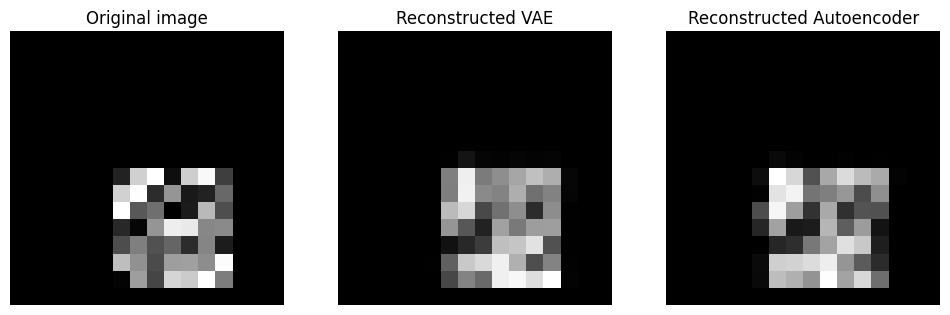

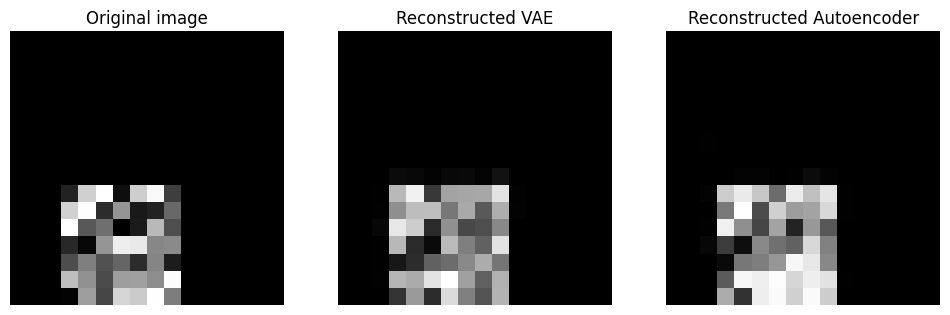

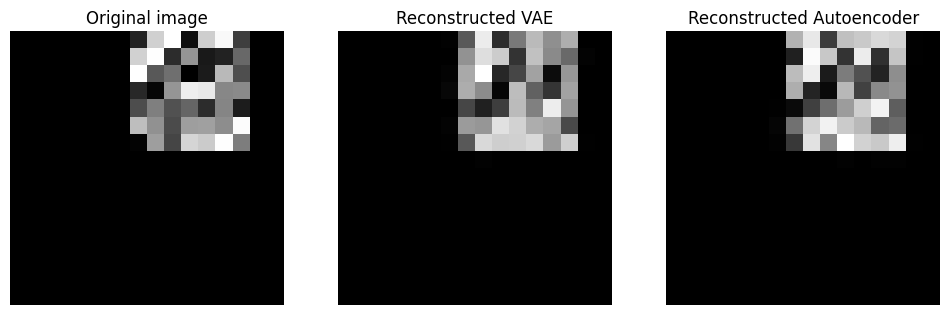

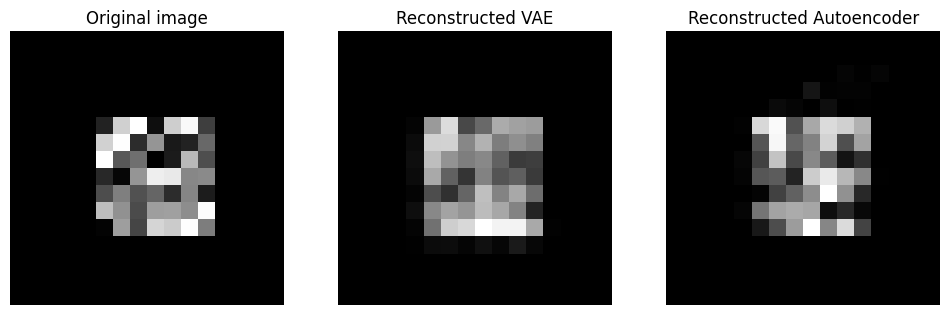

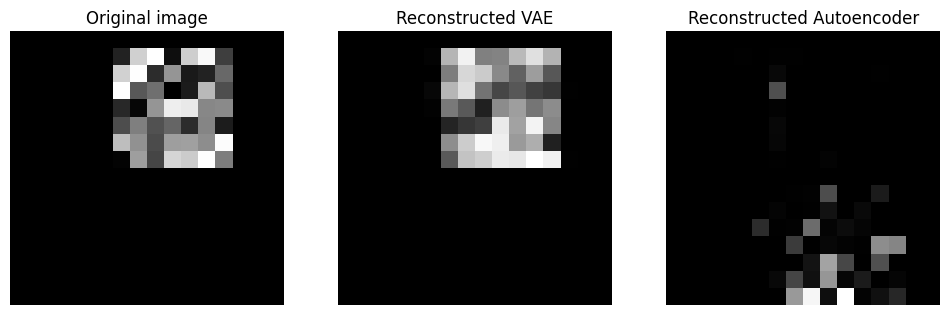

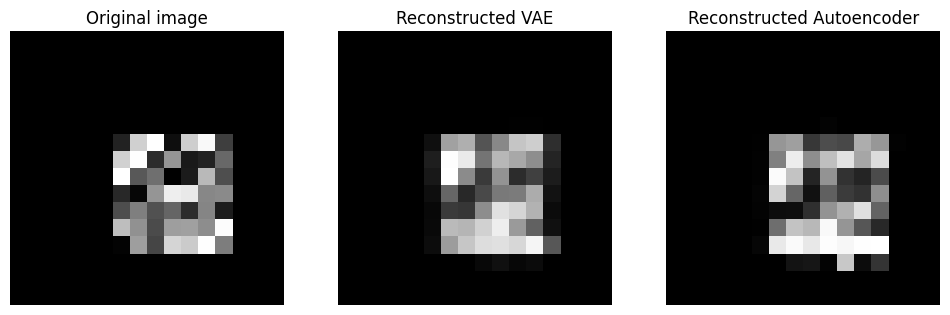

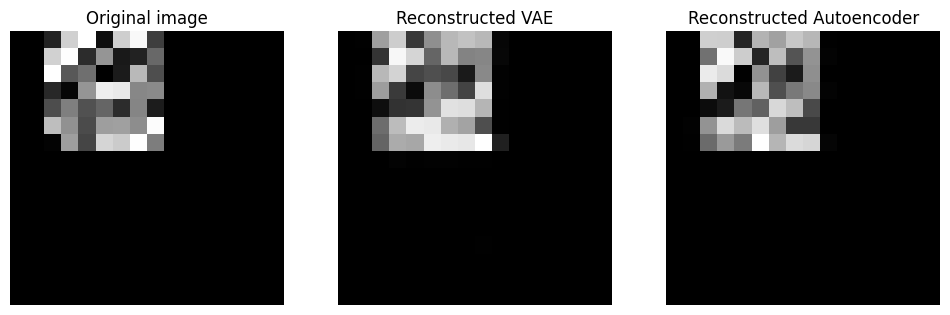

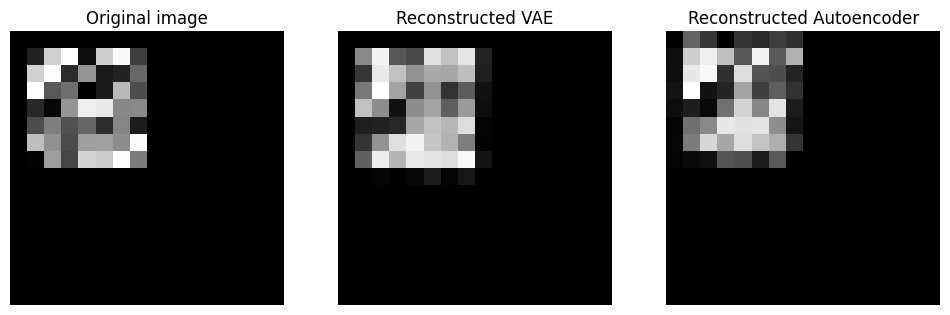

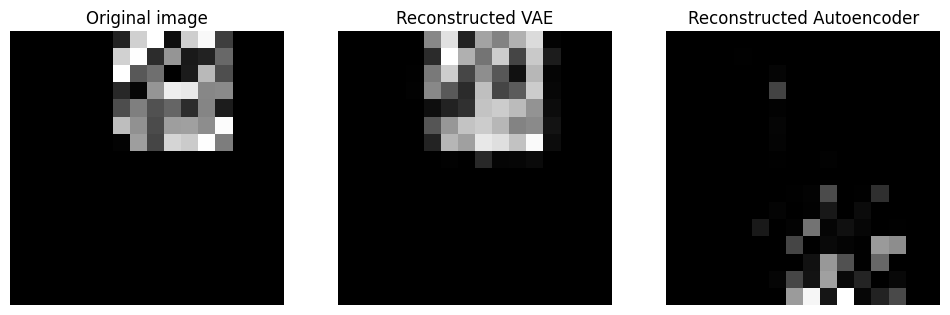

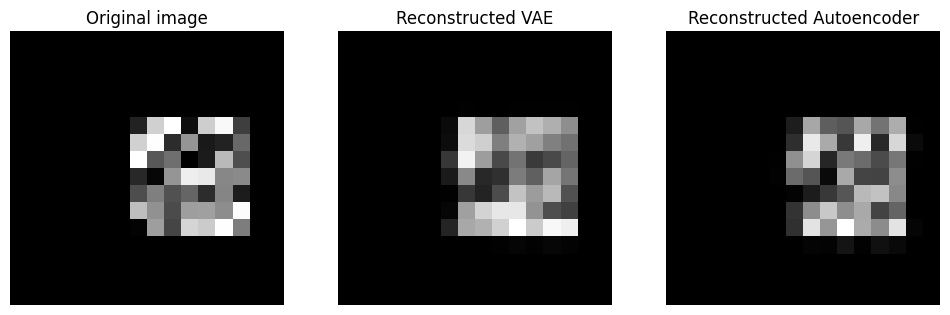

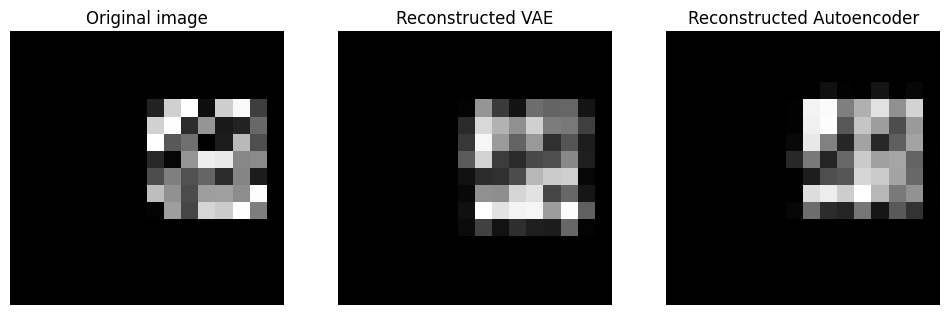

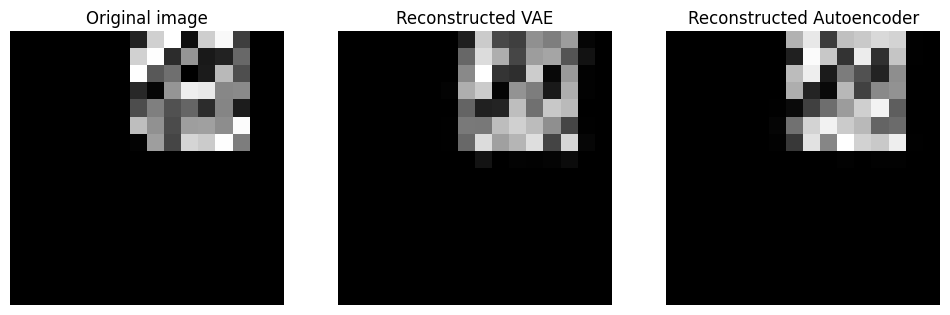

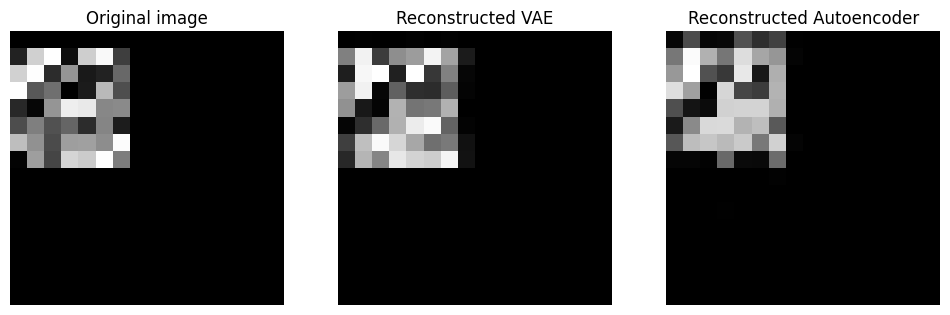

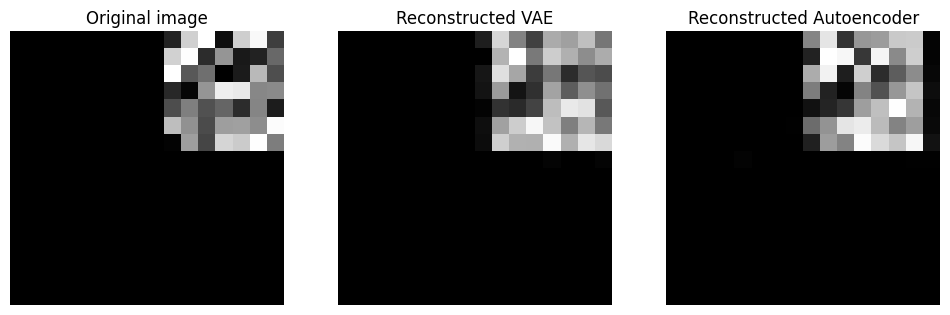

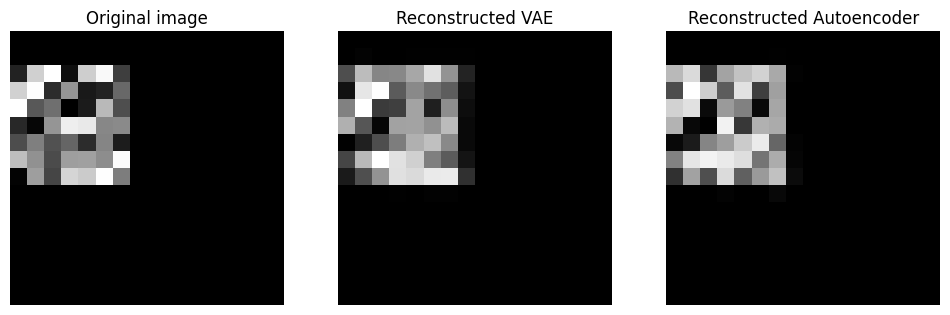

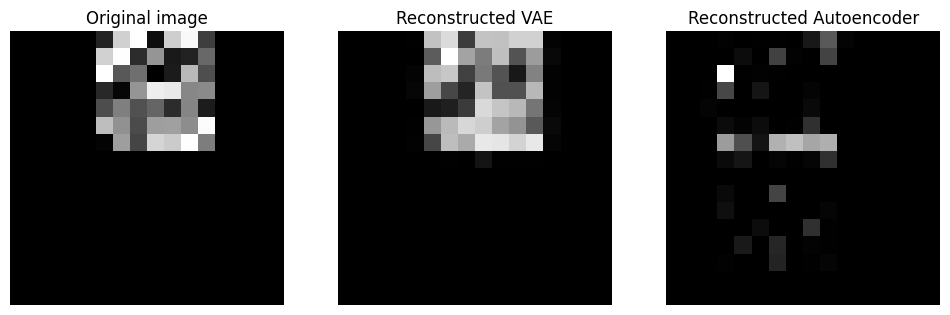

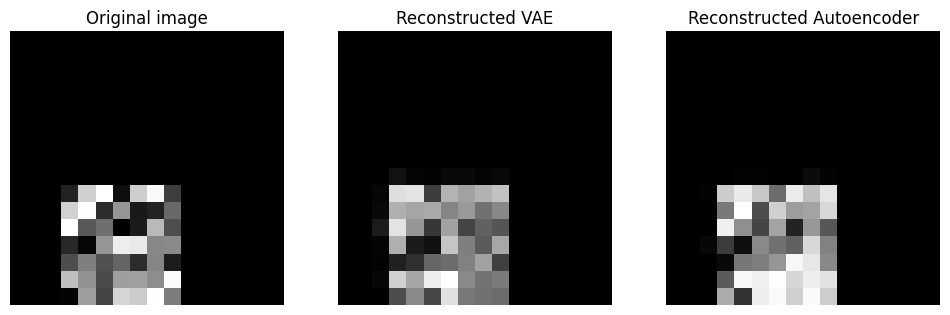

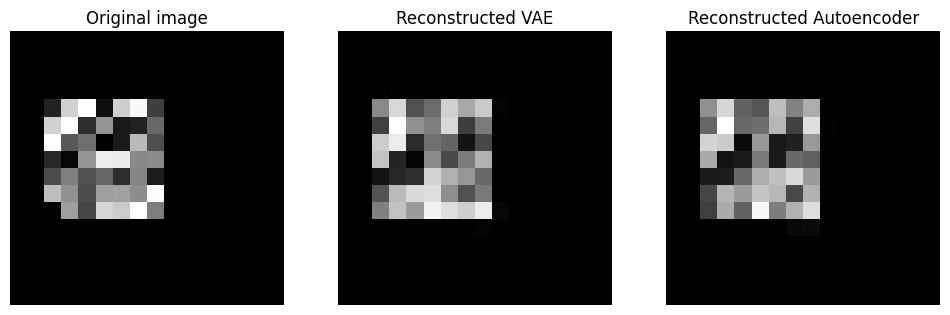

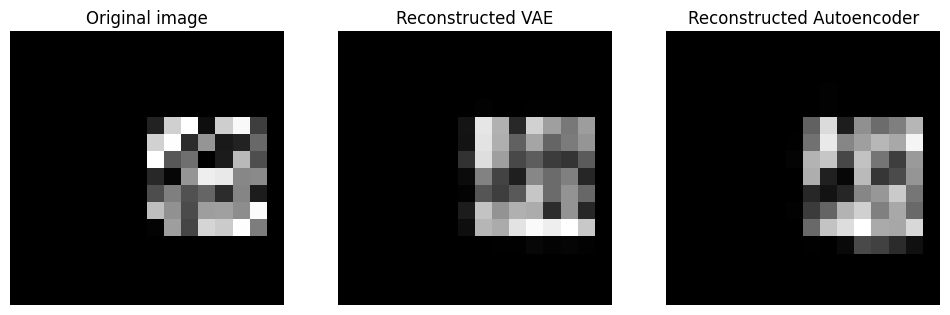

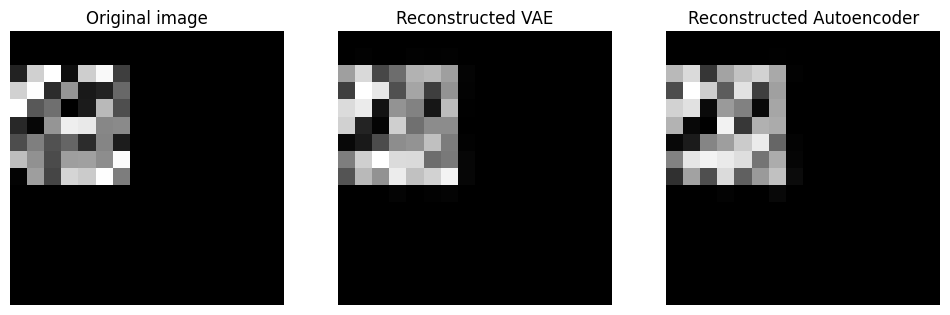

tensor([[ 1.0161, -0.4743],
        [-0.6538, -1.3102],
        [ 0.4992,  0.6587],
        [ 0.0451, -1.1522],
        [ 0.0177,  1.5622],
        [ 1.0667,  1.1788],
        [ 0.8236, -0.3198],
        [-0.5964, -0.4243],
        [-0.0676, -0.3277],
        [ 0.6351,  0.4234],
        [ 0.5709,  0.8452],
        [-0.2121,  1.2634],
        [-0.0509, -2.0983],
        [-0.6927,  0.8853],
        [-0.0870,  0.2597],
        [ 0.6589, -0.9200],
        [ 0.2420, -0.8461],
        [ 1.3037,  0.2689],
        [ 0.1377, -1.6360],
        [ 1.1806,  1.1652]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[ -9.7700,  -0.0621],
        [ 11.5188,  11.2502],
        [-18.0484,  -5.5196],
        [  8.7728,   6.4477],
        [  0.3916, -13.4806],
        [-13.7992, -11.8253],
        [-11.6212,  -0.6221],
        [ -5.3799,  18.6773],
        [-17.9595,   4.4419],
        [-17.2428,  -4.8218],
        [-17.4640,  -8.7020],
        [  0.4011,  -9.3422],
        [ 17.7514,   1.9749],
        

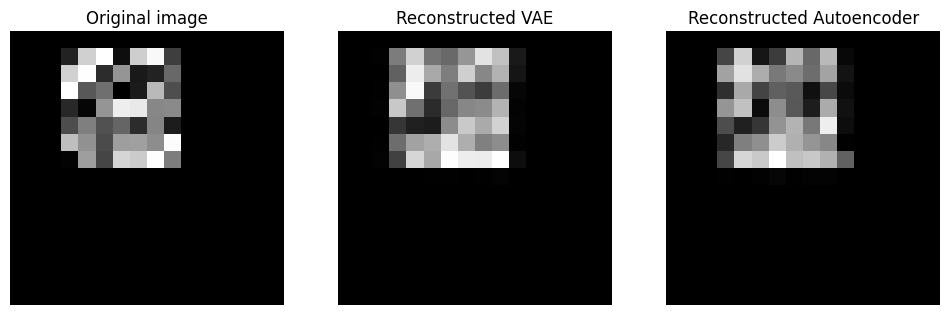

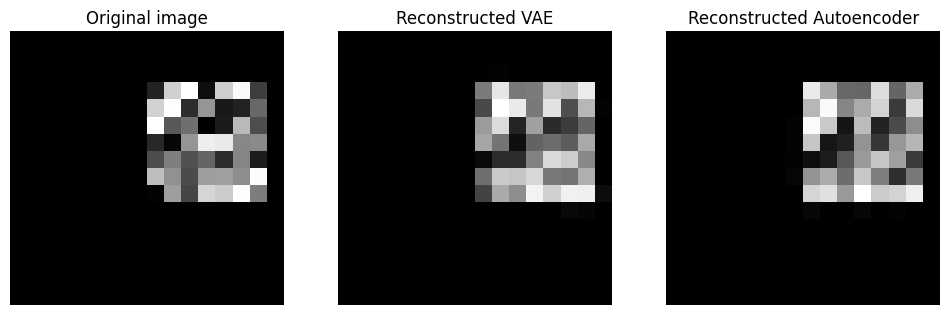

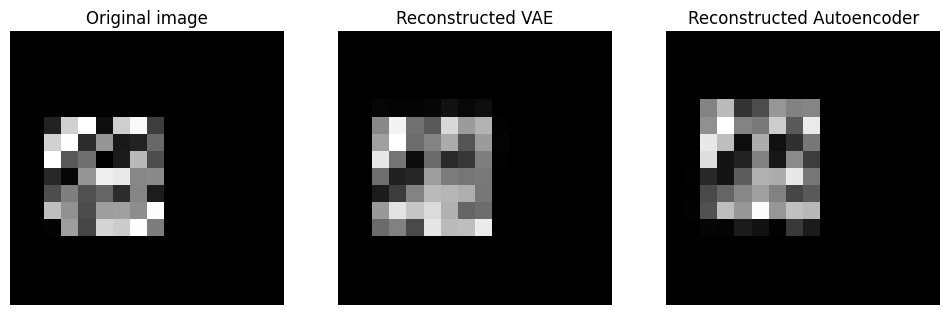

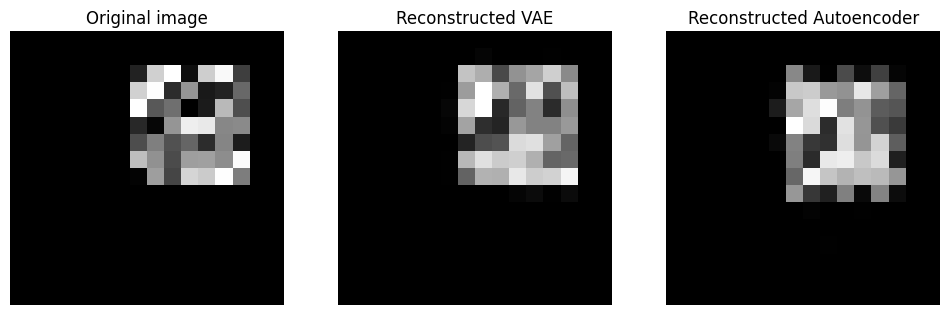

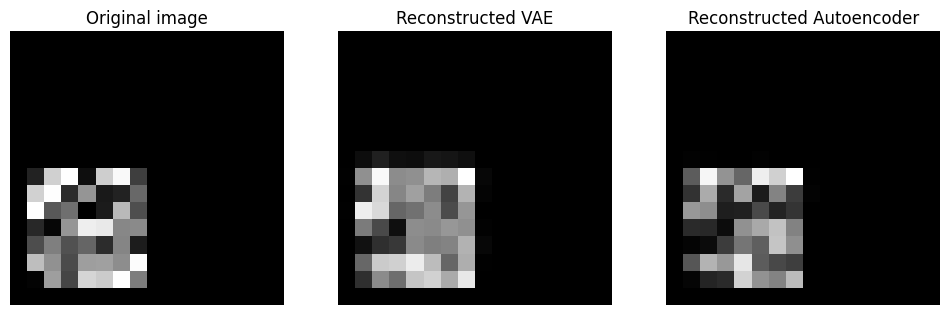

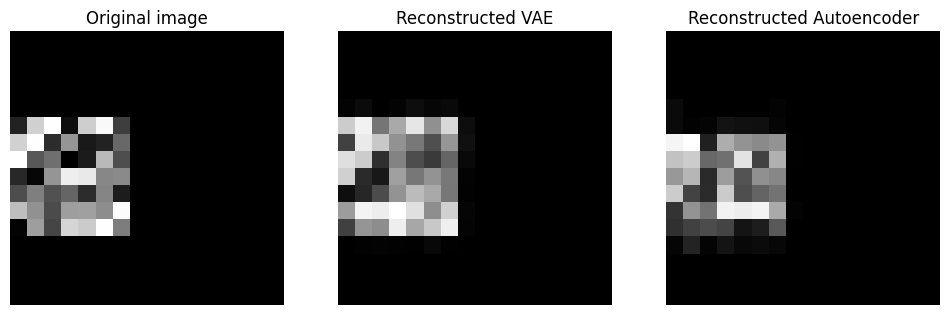

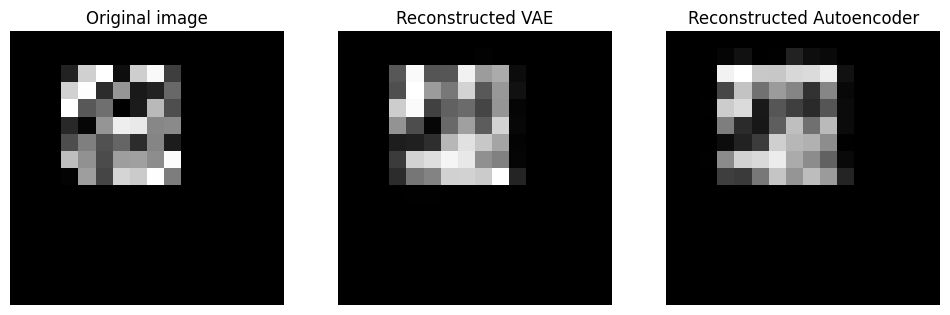

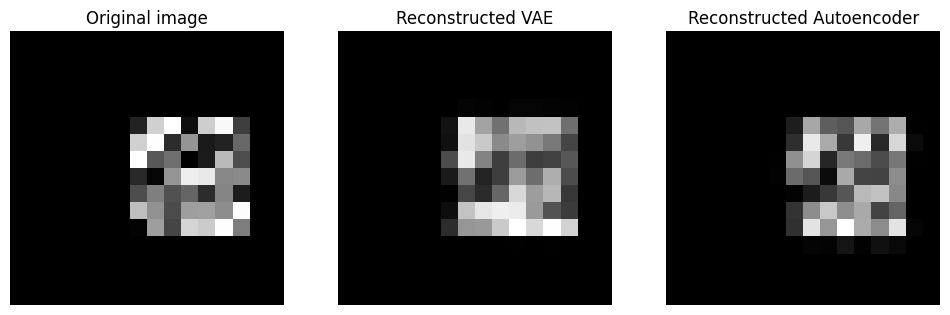

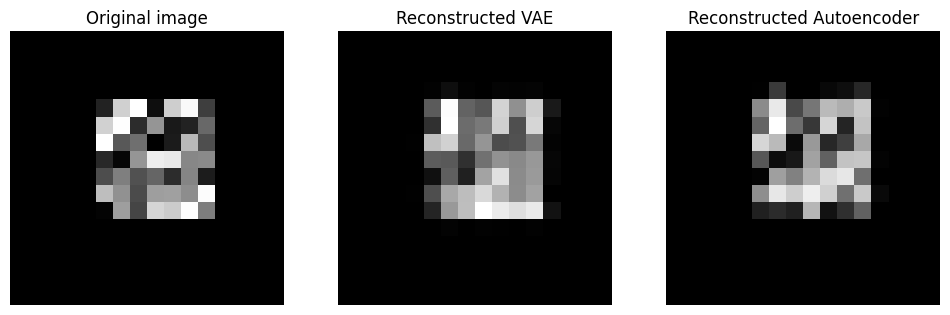

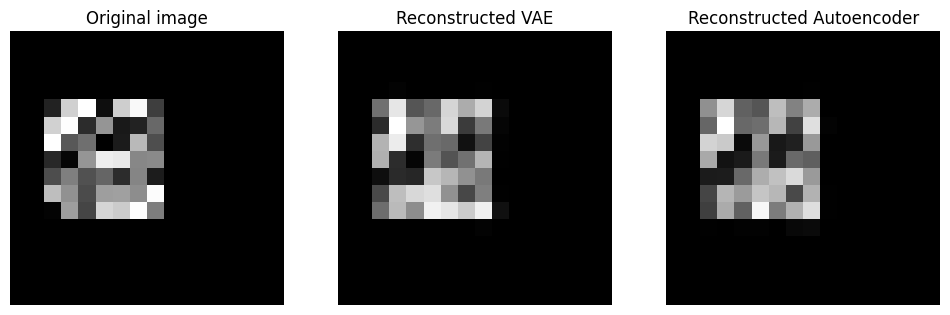

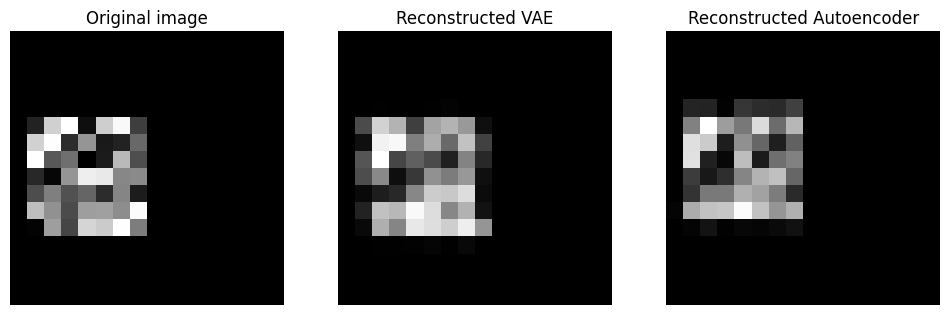

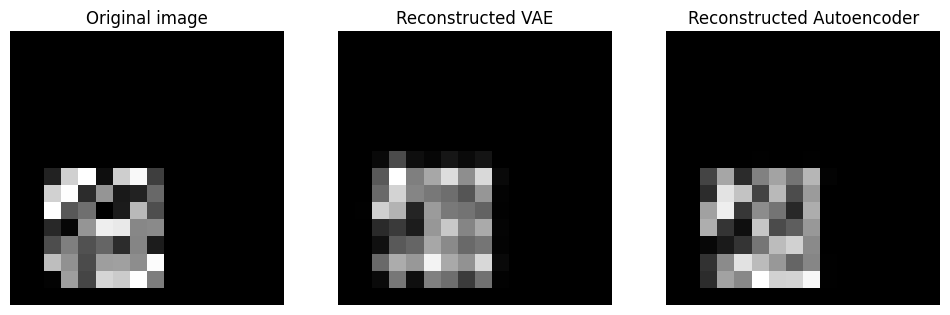

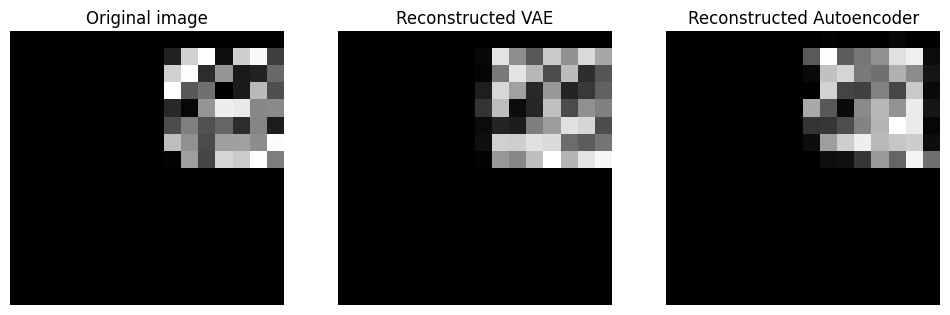

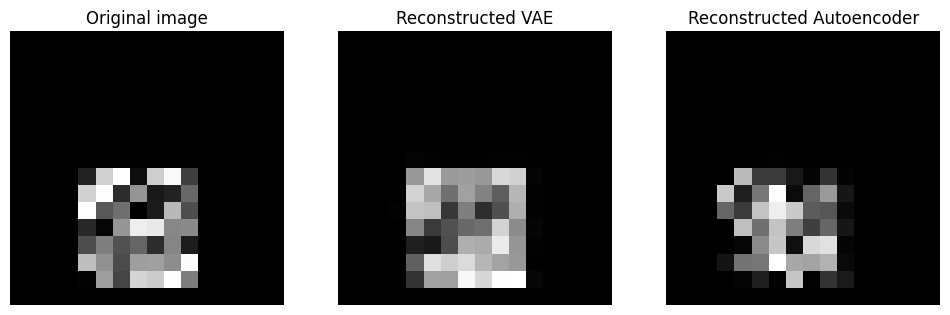

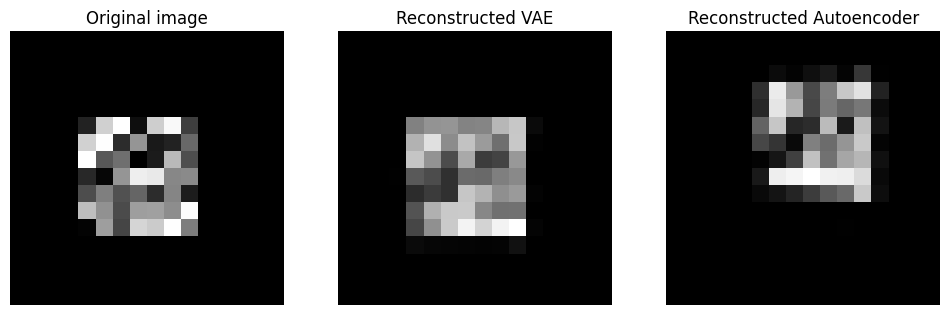

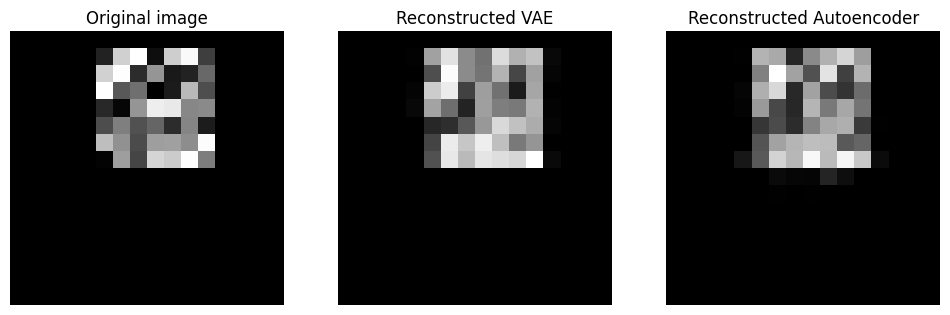

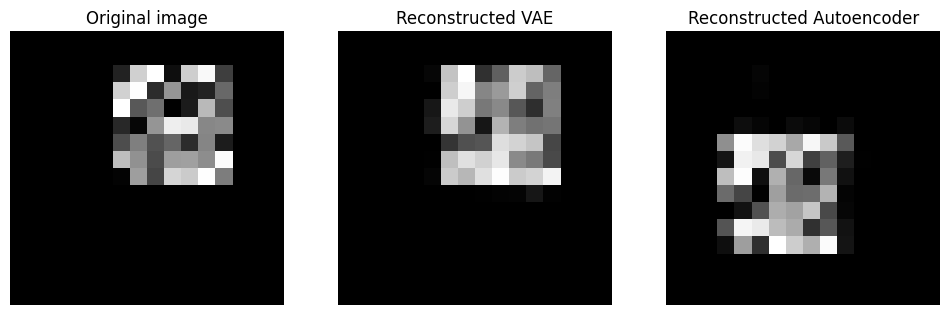

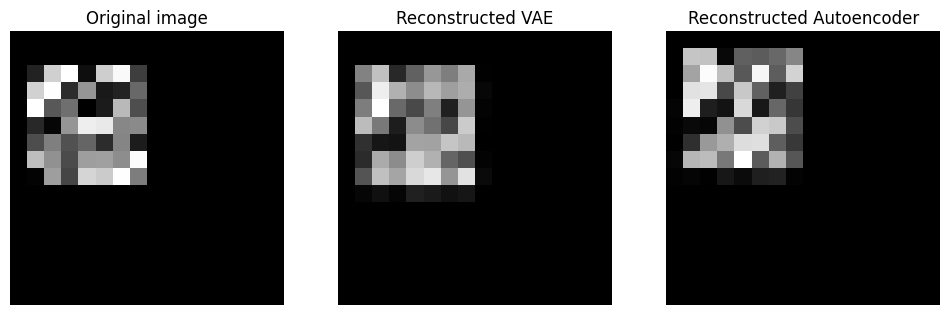

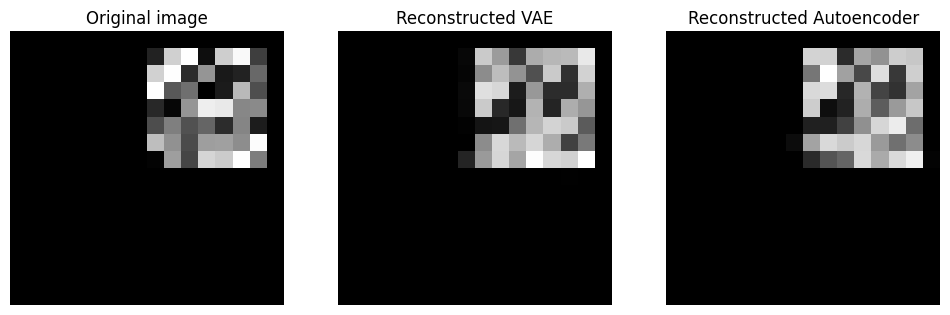

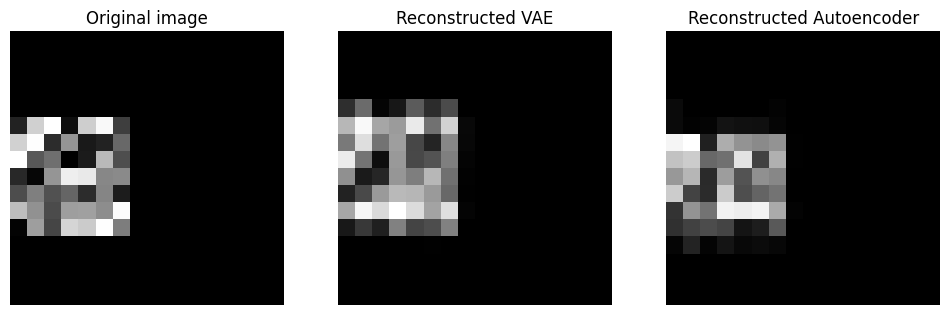

tensor([[ 0.3258,  2.1740],
        [-1.1201, -1.1416],
        [-0.0986,  1.5833],
        [-0.3515,  2.0090],
        [-0.6242, -0.4928],
        [ 0.5946, -0.7267],
        [-1.0067, -1.1522],
        [-1.0037, -1.7816],
        [-1.3127,  0.7988],
        [-0.7232, -0.5269],
        [ 0.5542,  0.4650],
        [-0.4206, -1.1427],
        [-0.7813,  0.2504],
        [-1.9093, -0.2945],
        [-0.5028,  0.6646],
        [-1.3153,  0.2105],
        [ 0.1059,  0.3218],
        [-0.4091,  1.1368],
        [-0.1302, -0.4790],
        [ 0.4852, -0.2492]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[ -0.1537, -17.2810],
        [ 10.9546,  17.5175],
        [  0.3916, -13.4806],
        [  6.2695, -11.5018],
        [ -5.3799,  18.6773],
        [ -9.9894,   2.5104],
        [ 10.9546,  17.5175],
        [ 14.4182,  14.9492],
        [  2.4371,   3.4377],
        [ -5.3799,  18.6773],
        [-17.2428,  -4.8218],
        [ 11.5188,  11.2502],
        [ -1.6401,   9.0245],
        

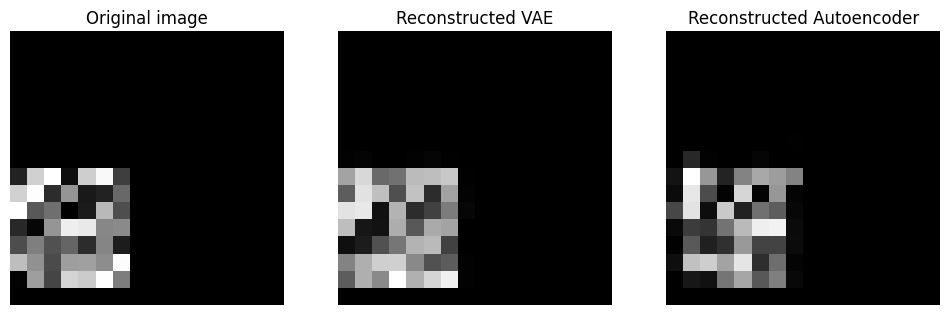

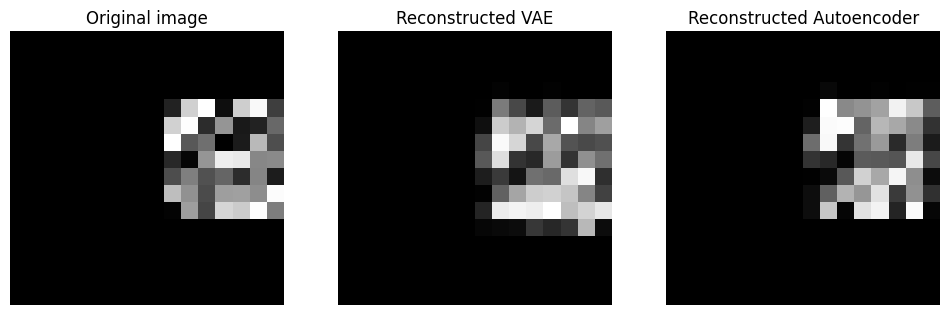

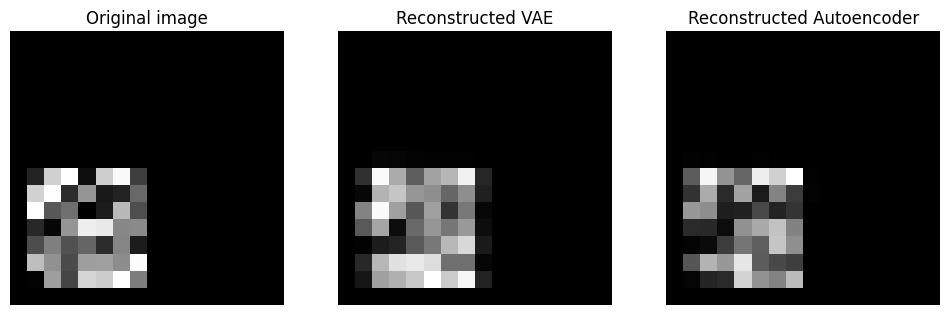

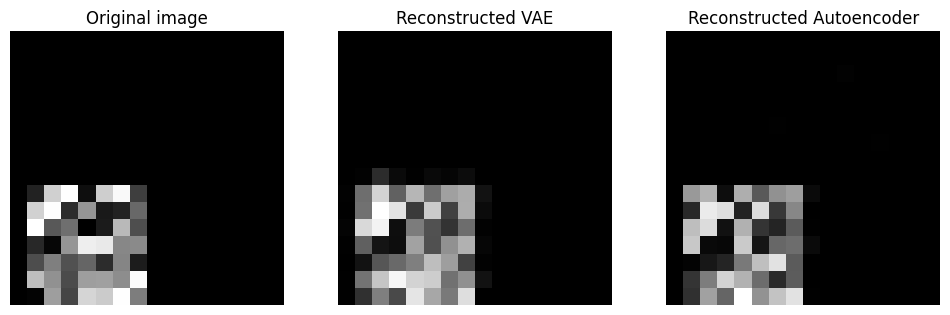

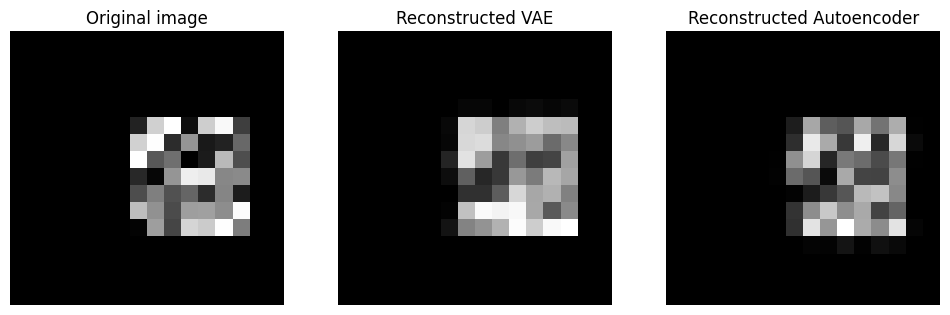

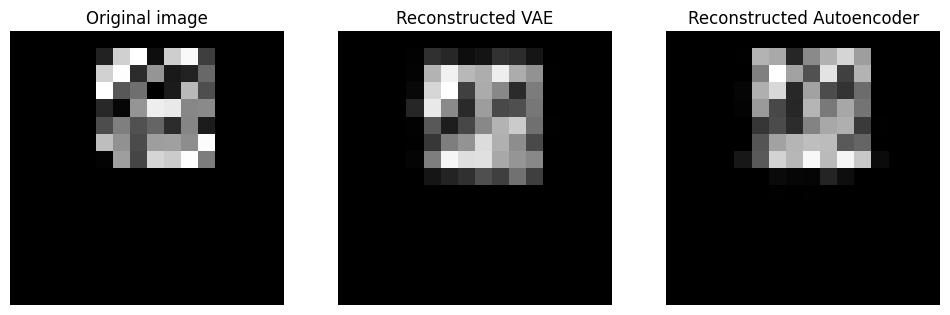

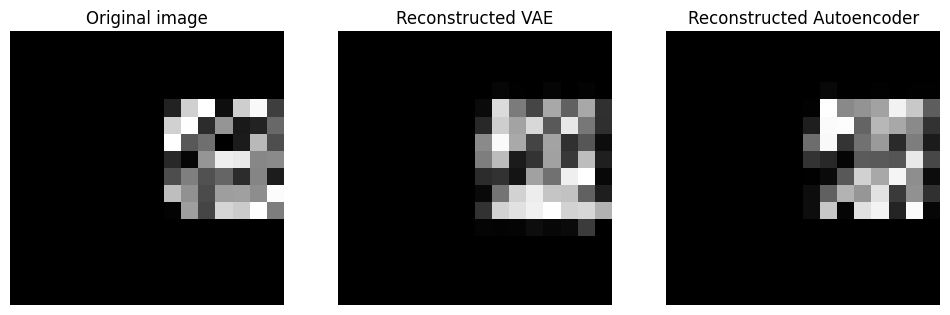

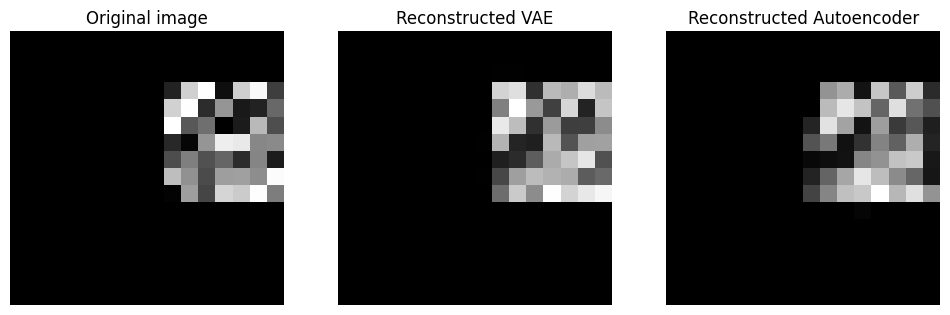

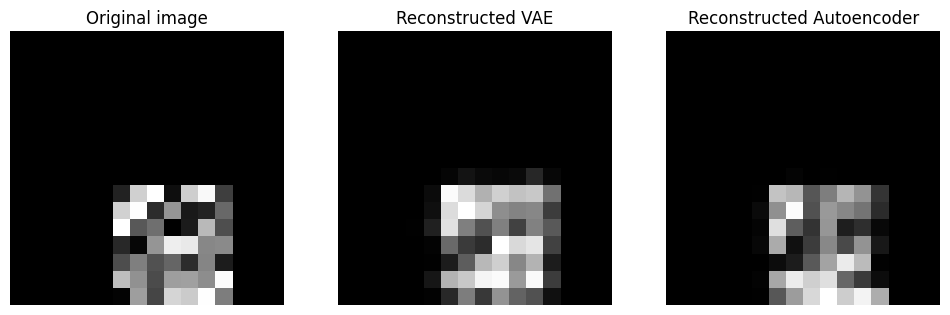

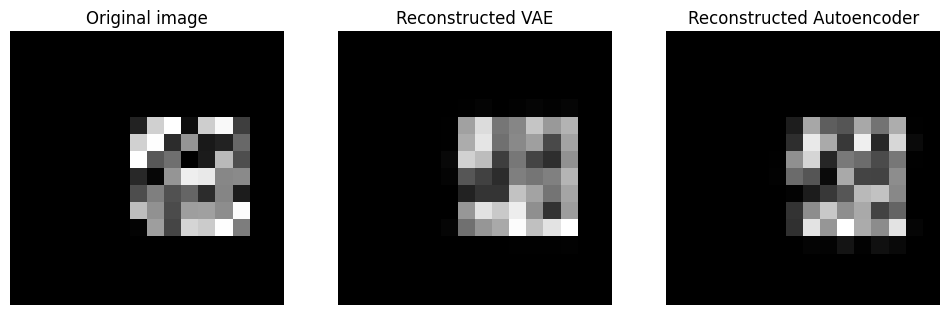

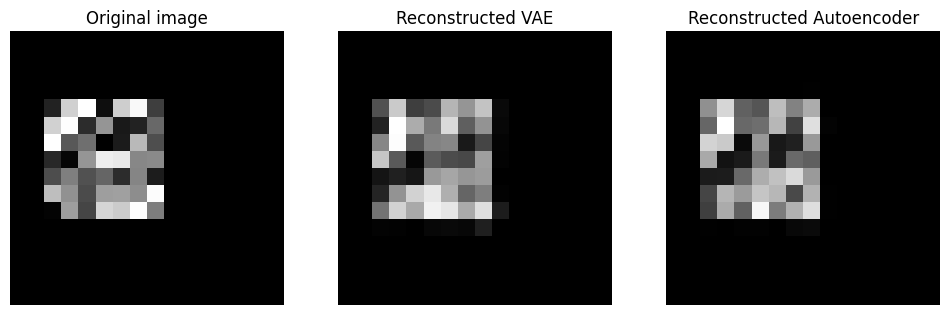

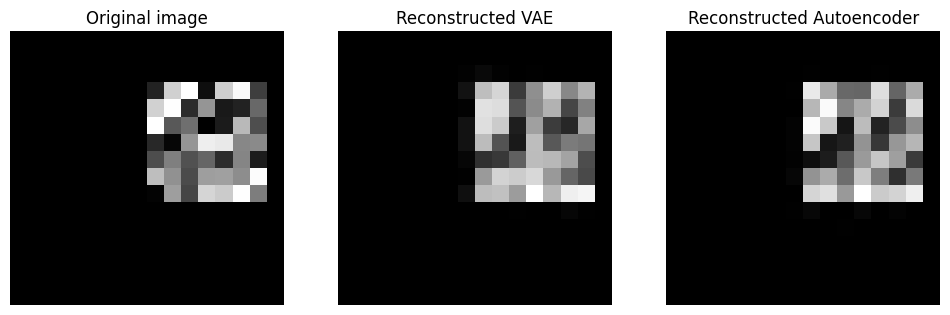

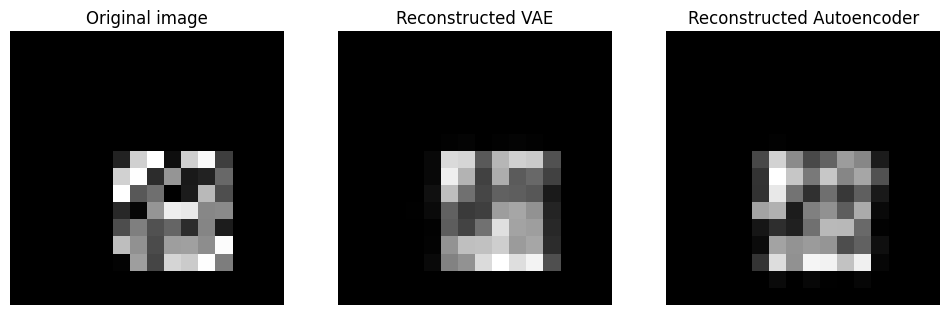

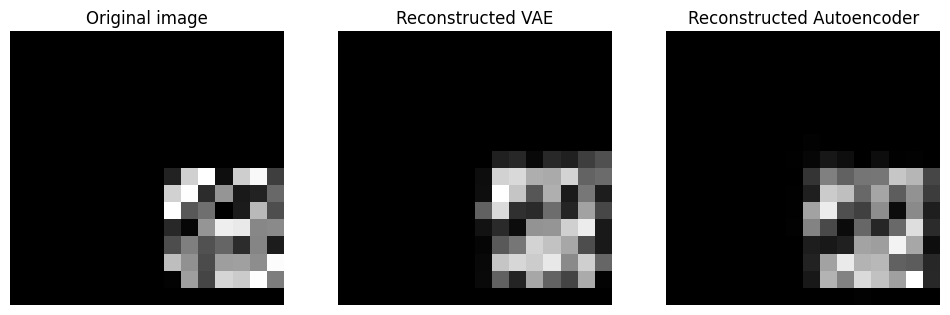

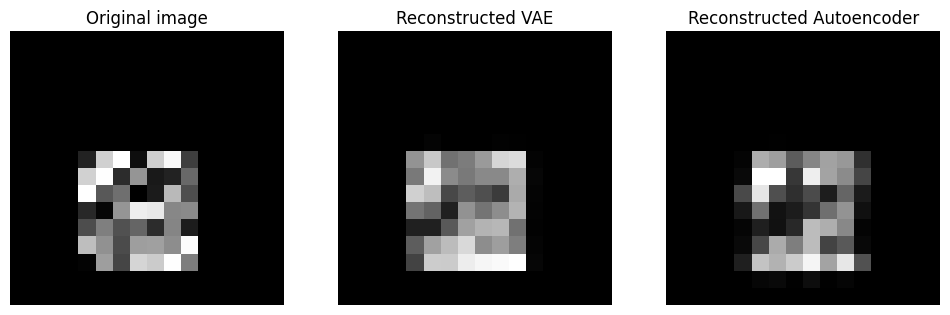

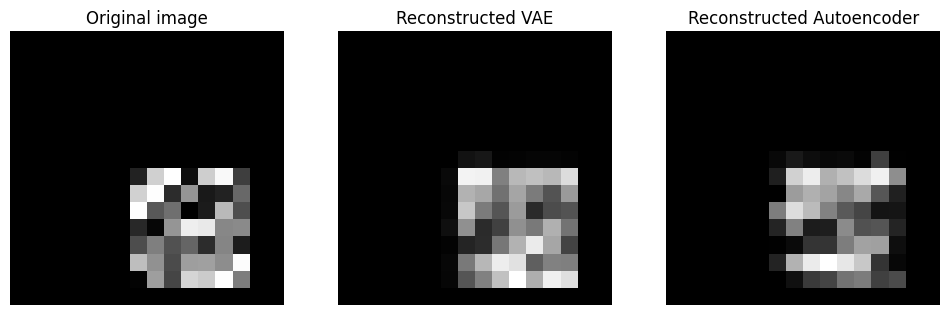

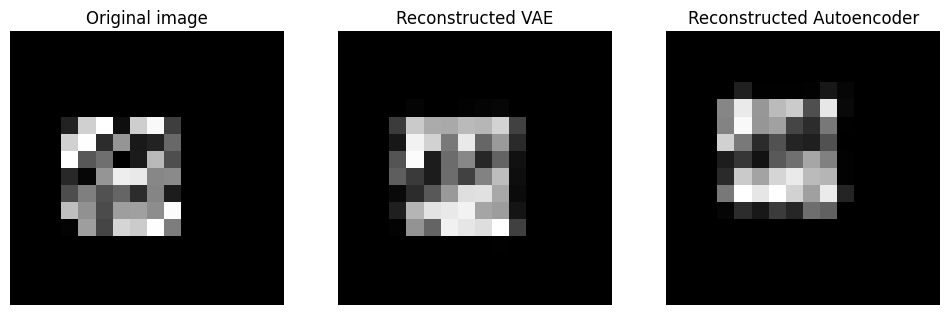

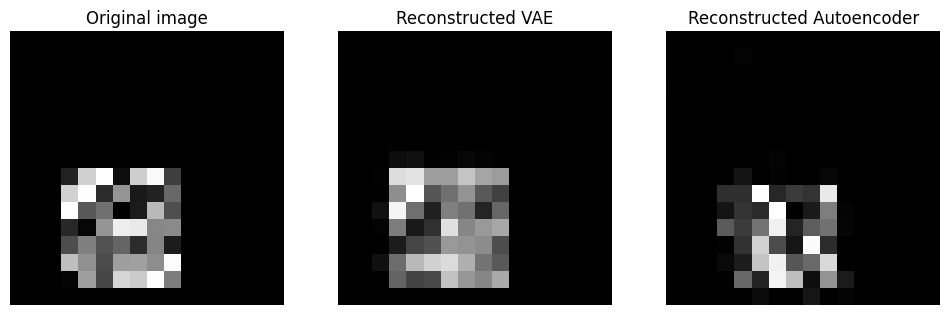

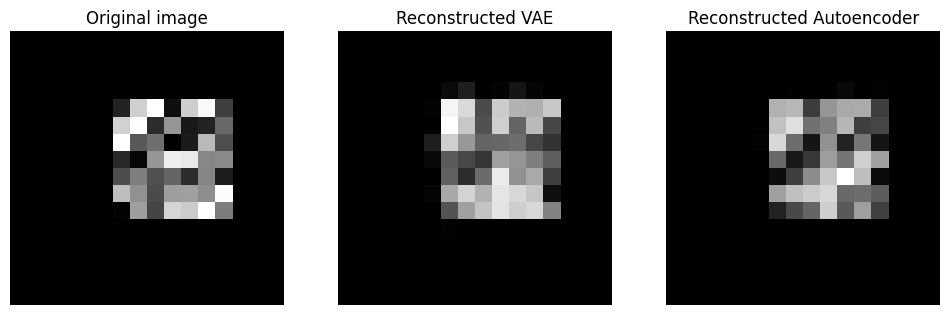

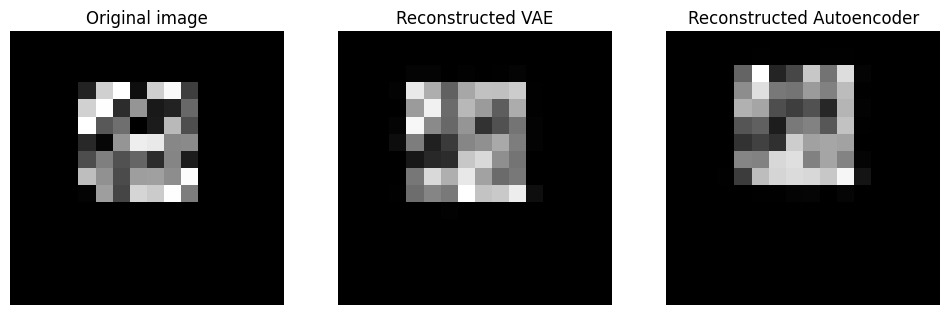

tensor([[-0.0335,  0.7693],
        [ 1.3066,  1.0413],
        [ 1.1347, -0.5532],
        [ 0.8900, -1.7878],
        [-1.0509,  1.0445],
        [ 1.1093,  1.2267],
        [-0.3459,  1.0688],
        [ 0.2387,  1.0005],
        [-0.0086,  1.1525],
        [ 0.1539, -2.2674],
        [-1.2664,  0.8837],
        [-1.9335,  0.3886],
        [-1.4633, -0.7629],
        [ 0.9493,  0.7942],
        [ 0.3890, -0.6789],
        [ 0.9379,  0.7620],
        [-0.4411,  0.6620],
        [ 0.6689, -0.3882],
        [-0.8317, -1.5217],
        [-1.0131,  1.3151]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[-13.6259,  -0.2757],
        [-14.4701,  -9.0297],
        [ -9.7700,  -0.0621],
        [ 12.2853,  -0.8599],
        [  3.4824,  -1.3145],
        [-13.7992, -11.8253],
        [  1.2617,  -3.8051],
        [-17.1080,  -5.5266],
        [-10.1192,  -7.4643],
        [ 16.2744,  -2.9384],
        [  3.1362,   0.7222],
        [  4.0709,   6.2197],
        [  2.7317,  17.7306],
        

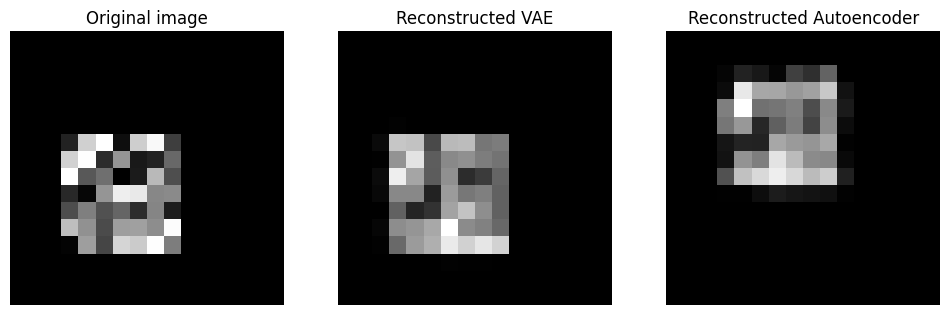

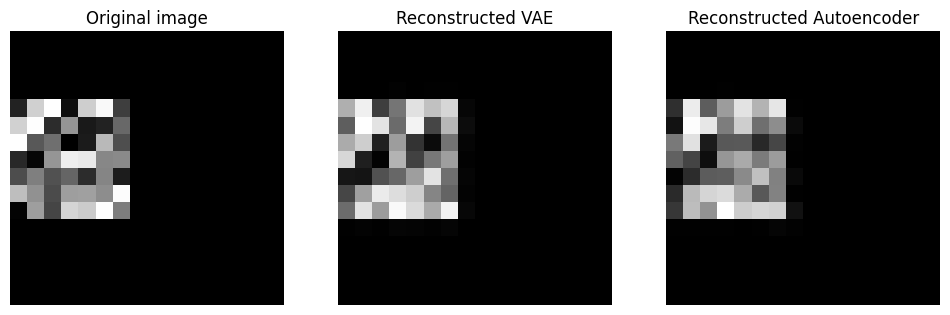

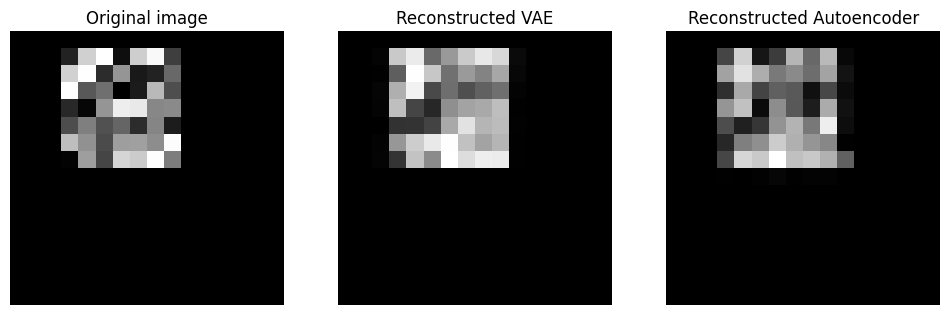

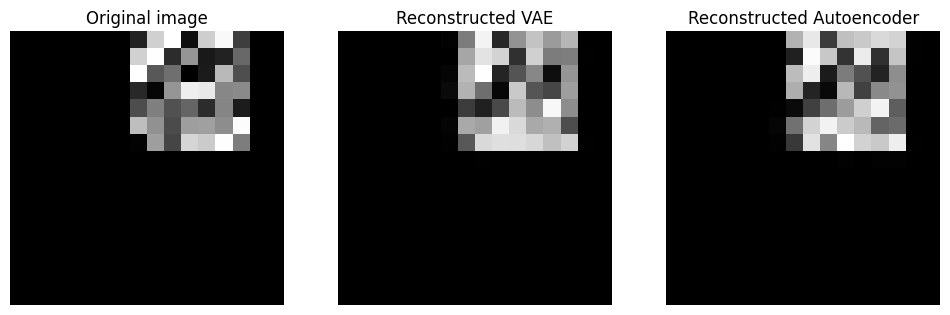

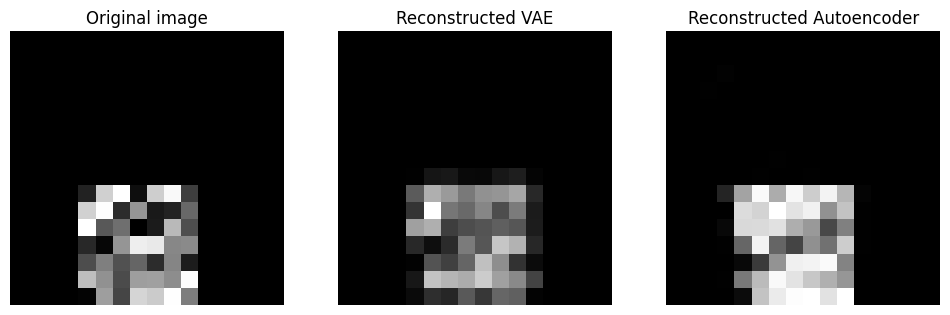

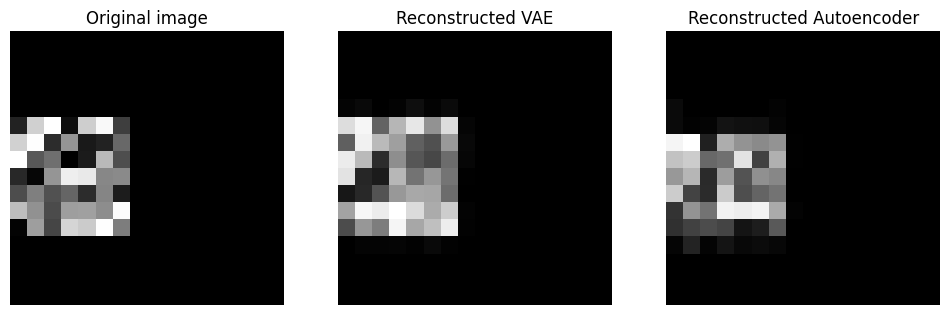

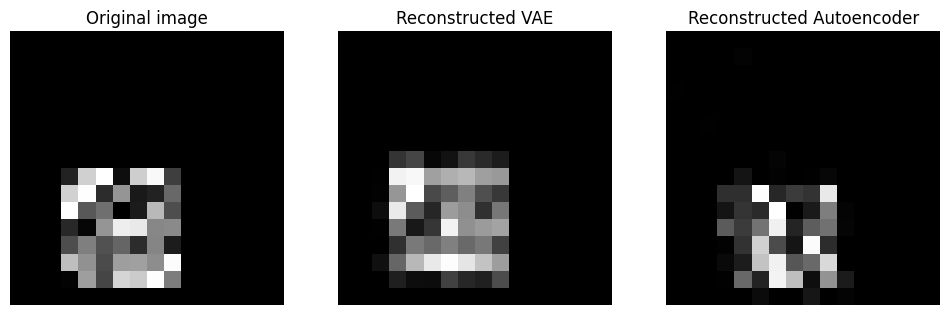

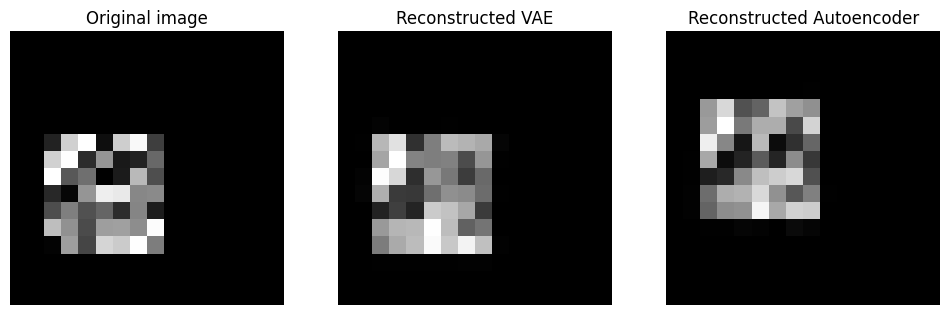

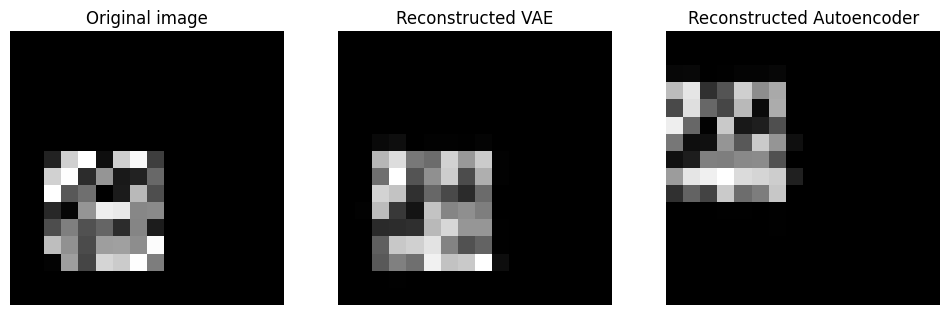

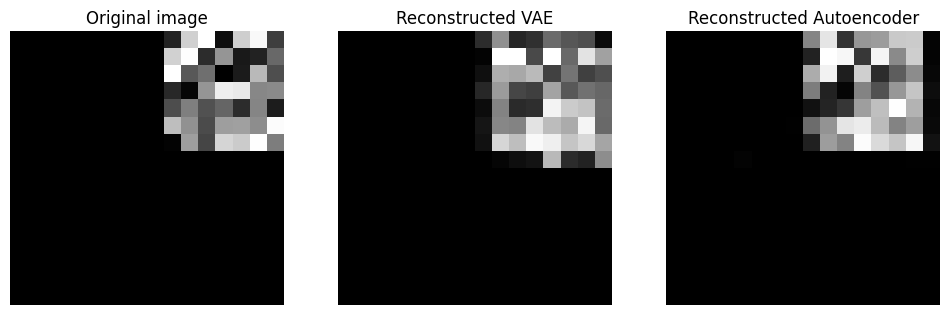

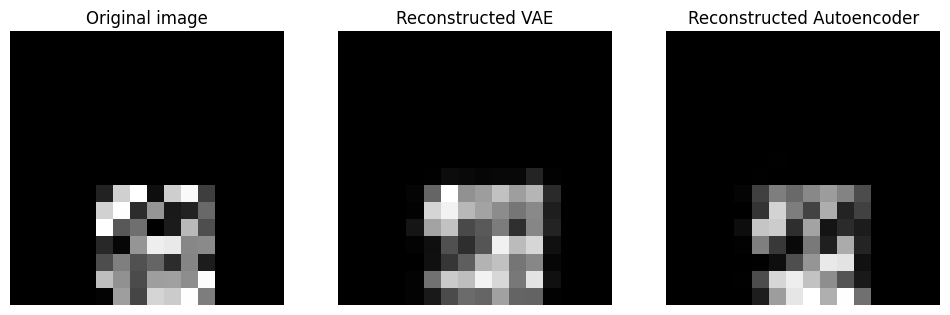

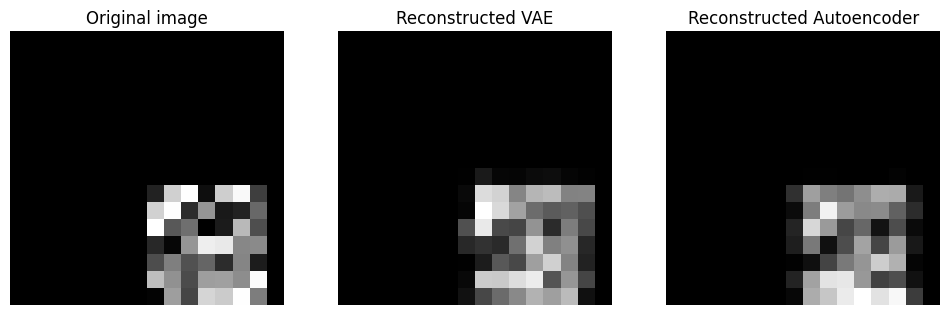

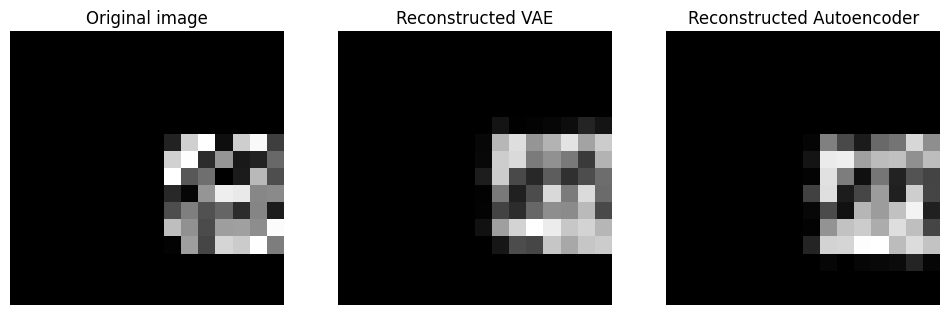

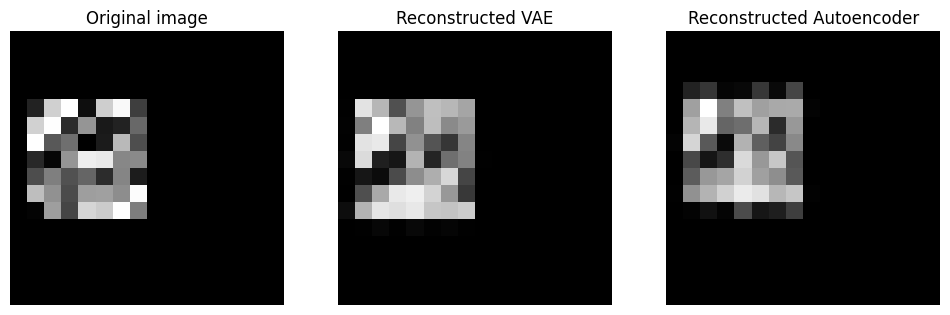

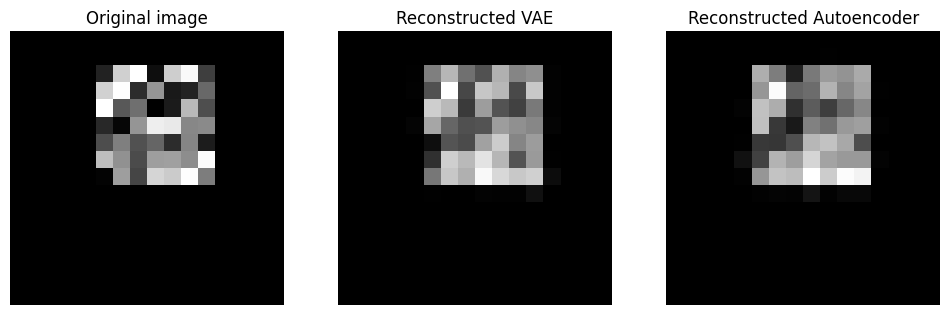

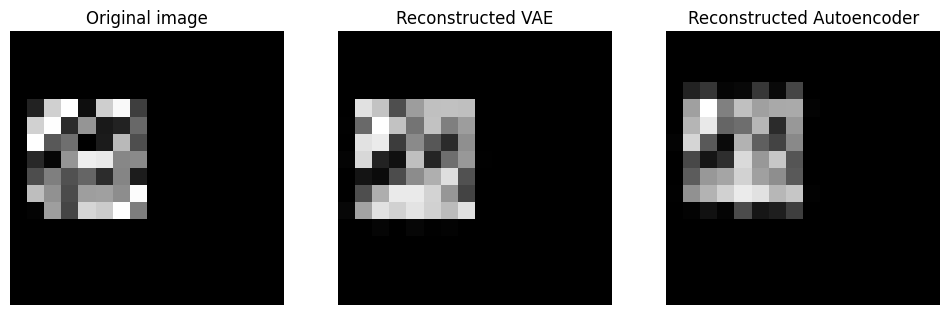

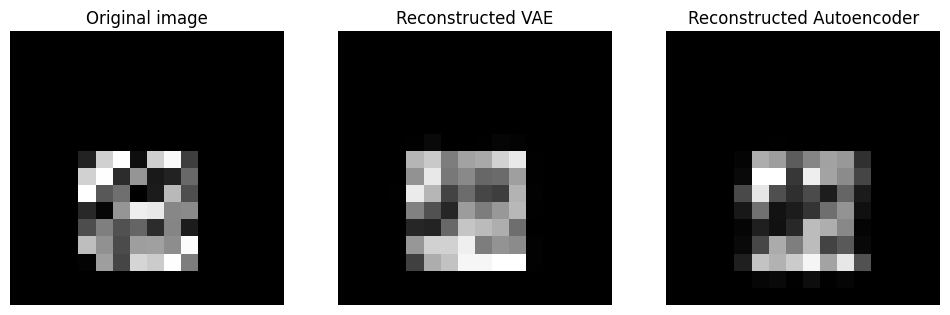

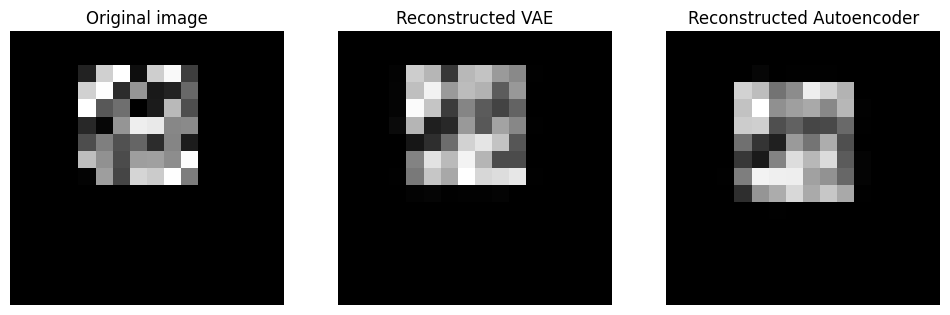

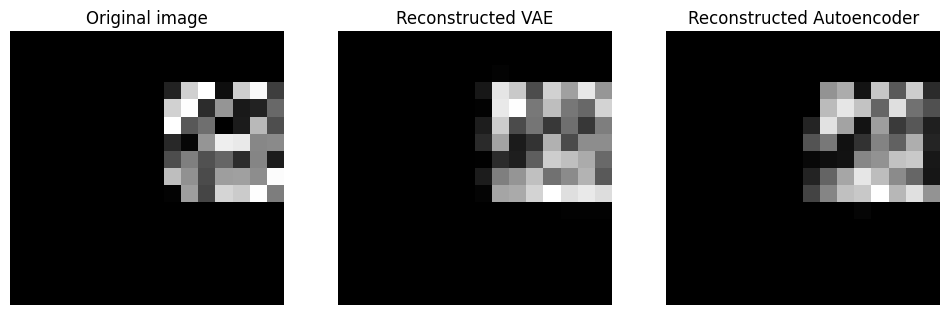

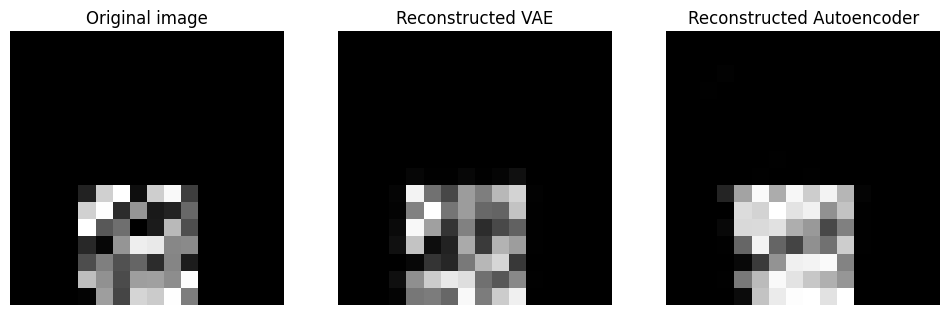

In [29]:
# Visualize

vae.eval()
sae.eval()

dataloader = dataloader_testing
bs = dataloader.batch_size

for data in dataloader:
    data = data.view(bs, image_vector_dim)
    
    data=data.to(DEVICE)

    data_vae, mean, variance, lat_vae = vae(data)
    data_sae, lat_sae                 = sae(data)

    print(lat_vae)
    print(lat_sae)
    
    data = data.view(bs, image_size[0], image_size[1])
    data_vae = data_vae.view(bs, image_size[0], image_size[1])
    data_sae = data_sae.view(bs, image_size[0], image_size[1])

    
    for i in range(bs):
        im0 = data[i]
        im0_np = im0.cpu().detach().numpy()
        im1 = data_vae[i]
        im1_np = im1.cpu().detach().numpy()
        im2 = data_sae[i]
        im2_np = im2.cpu().detach().numpy()
        
        plt.figure(figsize=(12,6))
        plt.subplot(1,3,1)
        plt.imshow(im0_np, cmap='gray')
        plt.axis('off')
        plt.title('Original image')
        plt.subplot(1,3,2)
        plt.imshow(im1_np, cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed VAE')
        plt.subplot(1,3,3)
        plt.imshow(im2_np, cmap='gray')
        plt.axis('off')
        plt.title('Reconstructed Autoencoder')
        
        plt.show()
        



test
[[ 2.65502048 -0.38517398]]
[[-2.03527427  0.18037815]]
[[[ 2.65502048 -0.38517398]]

 [[ 2.13387656 -0.32233483]]

 [[ 1.61273289 -0.25949574]]

 [[ 1.09158874 -0.19665657]]

 [[ 0.57044512 -0.13381748]]

 [[ 0.04930103 -0.07097834]]

 [[-0.47184253 -0.00813925]]

 [[-0.99298662  0.05469991]]

 [[-1.51413047  0.11753903]]

 [[-2.03527427  0.18037815]]]


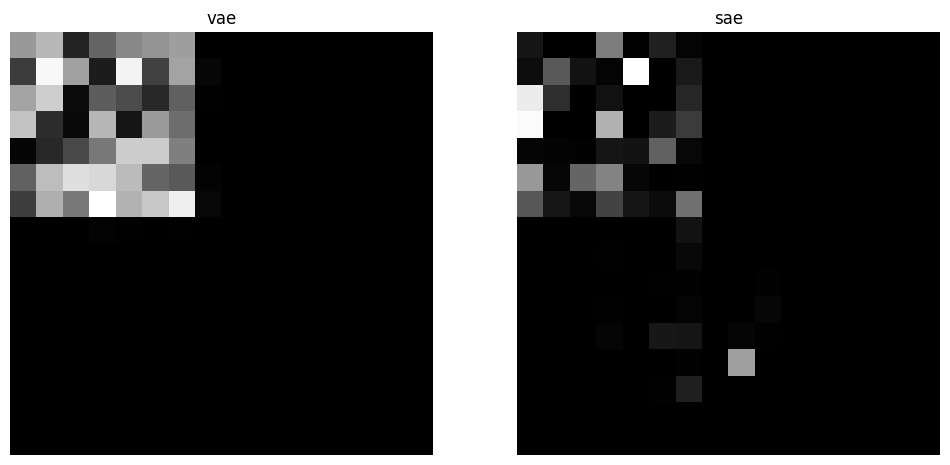

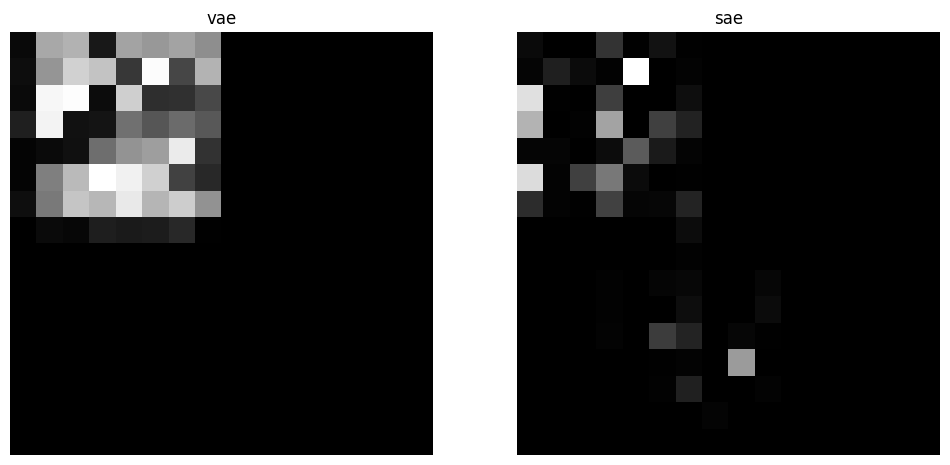

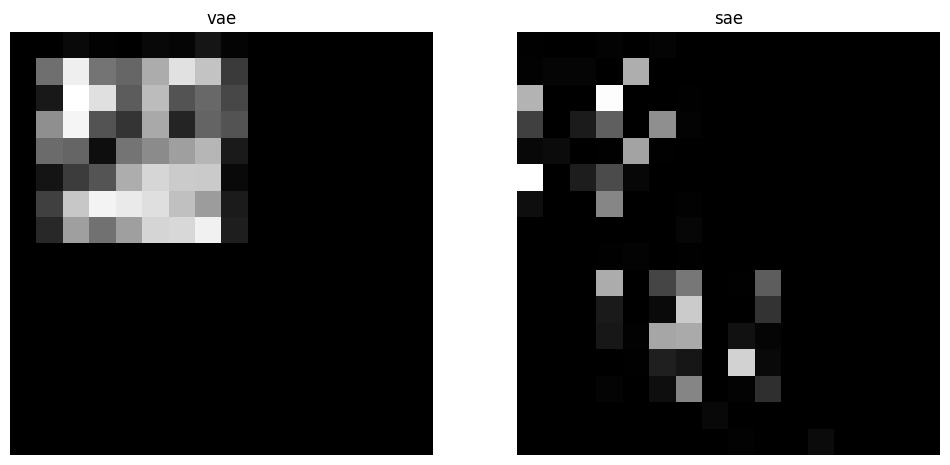

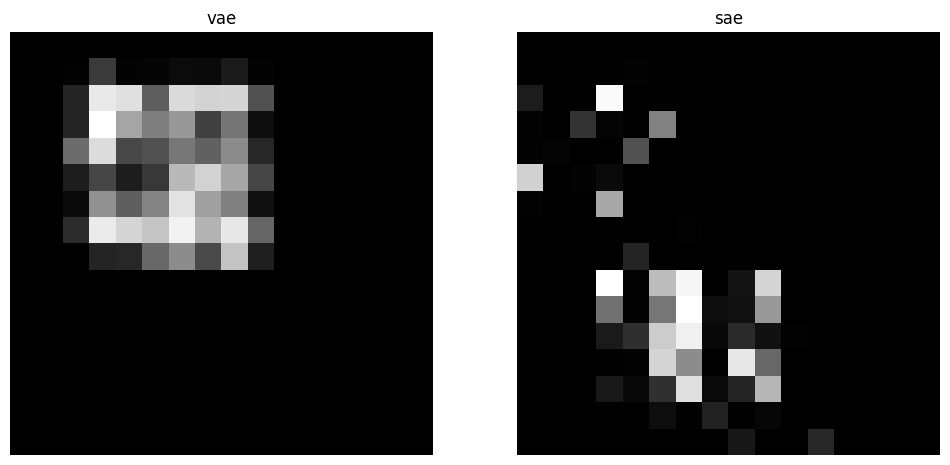

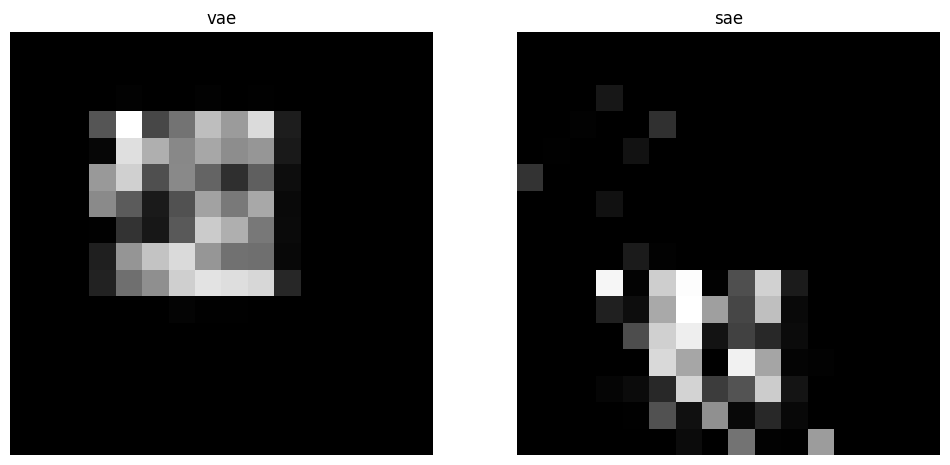

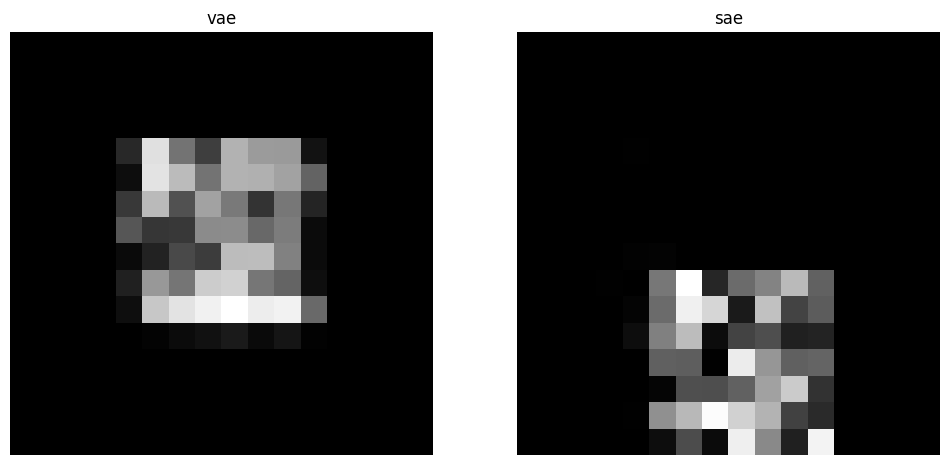

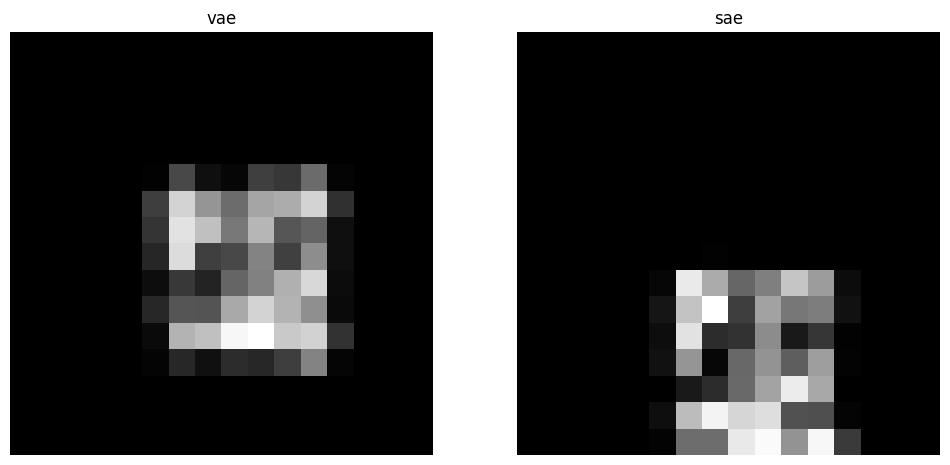

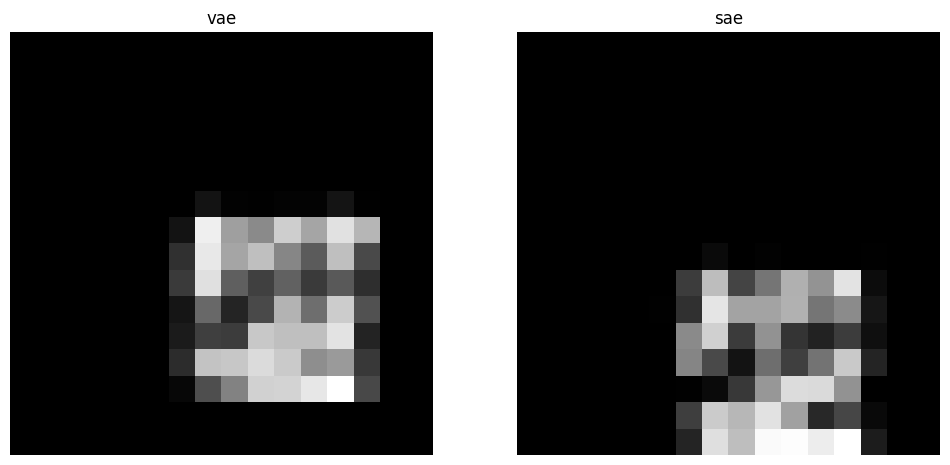

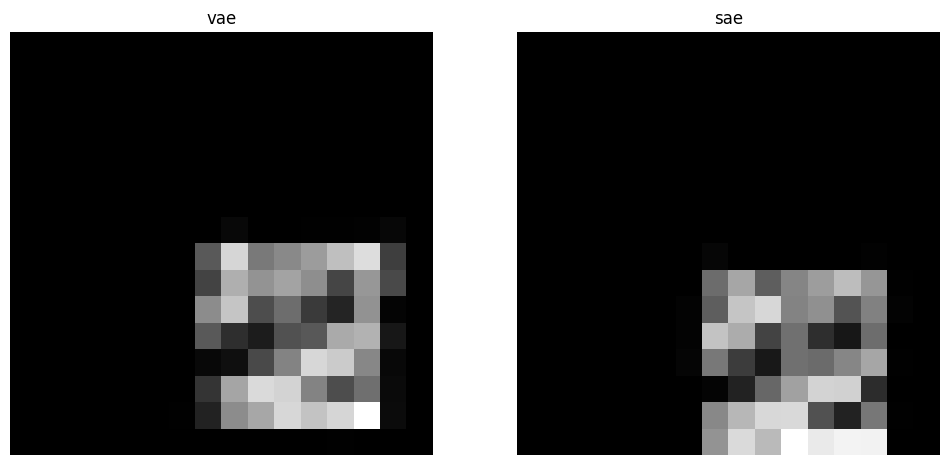

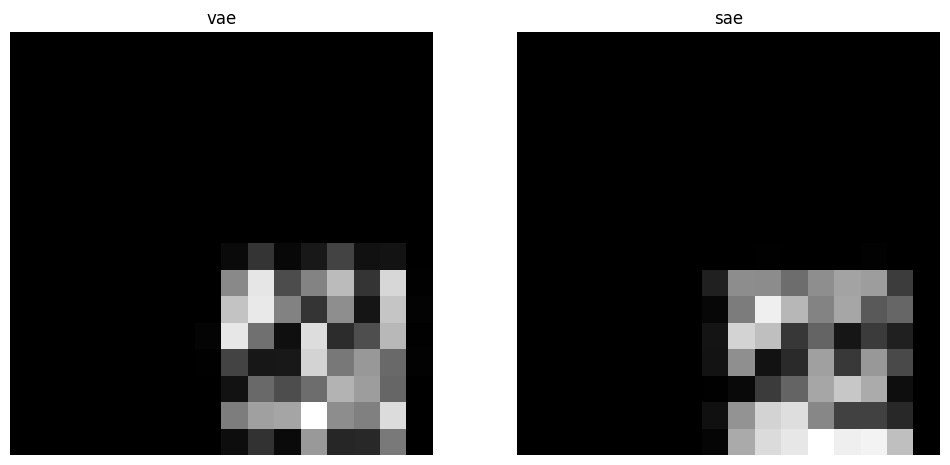

In [42]:
np.set_printoptions(suppress=True, floatmode='fixed')

n_points = 10

def linear_tensor_interpolation(p, n_points):
    start, end = p[0], p[1]
    pi = torch.stack([(1 - t) * start + t * end for t in torch.linspace(0, 1, n_points)])

    return pi

batch_tl = next(iter(dataloader_tl));
batch_tl = batch_tl.view(dataloader_tl.batch_size, image_vector_dim);
batch_tl = batch_tl.to(DEVICE);

batch_br = next(iter(dataloader_br));
batch_br = batch_br.view(dataloader_br.batch_size, image_vector_dim);
batch_br = batch_br.to(DEVICE);

batch_vae_tl, mean_tl, variance_tl, lat_vae_tl = vae(batch_tl);
batch_vae_br, mean_br, variance_br, lat_vae_br = vae(batch_br);

batch_sae_tl, lat_sae_tl = sae(batch_tl);
batch_sae_br, lat_sae_br = sae(batch_br);

get_mean(lat_vae_tl)

interpolated_points = linear_tensor_interpolation((lat_vae_tl, lat_vae_br), n_points)
print("test")
print(lat_vae_tl.cpu().detach().numpy())
print(lat_vae_br.cpu().detach().numpy())
print(interpolated_points.cpu().detach().numpy())

vae_decoder = vae.get_decoder()
sae_decoder = sae.get_decoder()

im_vae = vae_decoder(linear_tensor_interpolation((lat_vae_tl, lat_vae_br), n_points));
im_vae = im_vae.view(n_points, image_size[0], image_size[1])

im_sae = sae_decoder(linear_tensor_interpolation((lat_sae_tl, lat_sae_br), n_points));
im_sae = im_sae.view(n_points, image_size[0], image_size[1])



for x in range(n_points):
    imv = im_vae[x]
    imv = imv.cpu().detach().numpy()

    ims = im_sae[x]
    ims = ims.cpu().detach().numpy()
    
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    plt.imshow(imv, cmap='gray')
    plt.axis('off')
    plt.title('vae')
    
    plt.subplot(1,2,2)
    plt.imshow(ims, cmap='gray')
    plt.axis('off')
    plt.title('sae')
    

#print(lat_vae_tl.cpu().detach().numpy())
#print(lat_vae_br.cpu().detach().numpy())

